In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import dill

from python.mappings import FOOTBALL_LEAGUES_MAPPING, TEAMS_RANKING_MAPPING, EUROPEAN_TOURNAMENTS_MAPPING, PLAYERS_OUTSIDE_TOP5

from scipy.stats import norm, skew
from scipy.stats import probplot
from scipy.stats import f_oneway, shapiro, levene, kruskal

from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, NuSVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

%matplotlib inline

In [3]:
# Constant variables
TABLE_SIZE = 1546
TRAIN_RATIO = 0.8

In [4]:
# Joins train and test datasets together to simplify the process
def concat_df(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

# Divides the overall dataset into train and test 
def divide_df(df):
    train_size = int(TABLE_SIZE*TRAIN_RATIO)
    
    return df.loc[:train_size - 1], df.loc[train_size:] 

In [5]:
train_data = pd.read_csv('data/train_stats.csv')
test_data = pd.read_csv('data/test_stats.csv')
all_data = concat_df(train_data, test_data)
df_train, df_test = divide_df(all_data)

In [6]:
clean_sheets = pd.read_csv('data/footballers_clean_sheets.csv')
popularity = pd.read_csv('data/footballers_popularity.csv')

In [7]:
all_data = all_data.merge(right=clean_sheets, on=['Name'], how='left')
all_data = all_data.merge(right=popularity, on=['Name'], how='left')

In [8]:
all_data['Clean Sheets %'].fillna(value=0, inplace=True)
all_data['Popularity'].fillna(value=1, inplace=True)

**1. PREPARATION STEP: Cleaning the data**

In [9]:
all_data.drop(['Player_URL', 'Team_URL'], axis=1, inplace=True)

In [10]:
# Cleans the columns containing commas 
def clean_comma(column):
    column = column.strip()
    column = column[:column.find(',')] + '' + column[column.find(',') + 1:]
    return column

# Cleans the columns containing '\t' symbol
def clean_tab(column):
    return column.strip().replace('\t', '')

In [11]:
comma_columns = ['Team', 'Position']
tab_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
               'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP',
               'Drb_y', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in comma_columns:
    all_data[column] = all_data[column].apply(clean_comma)
    
for column in tab_columns:
    all_data[column] = all_data[column].apply(clean_tab)

In [12]:
# Some columns with integer values contain symbol '-' instead of 0. The function fixes it
def remove_dashes(column):
    if column == '-':
        return 0
    return column

In [13]:
dash_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
                'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Drb_y', 'Blocks', 'OwnG', 'KeyP',
                'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in dash_columns:
    all_data[column] = all_data[column].apply(remove_dashes)

In [14]:
# Now we have 'Value' variable containing market values in thousands or millions, but we want to get just an integer
def value_scaling(value):
    value = value.strip()
    
    if value.endswith('k'):
        return int(float(value[value.find('€')+1:value.find('k')]) * 10**3)
    elif value.endswith('m'):
        return int(float(value[value.find('€')+1:value.find('m')]) * 10**6)

In [15]:
all_data['Value'] = all_data['Value'].apply(value_scaling)

In [16]:
# We can divide 'Apps' variable because the number of appearances in starting squad is demonstrated in parentheses 
def appearances_division(apps):
    return apps[:apps.find('(')], apps[apps.find('(')+1:apps.find(')')]

In [17]:
all_data['Overall_Apps'], all_data['Start_Apps'] = zip(*all_data['Apps'].apply(appearances_division))

In [18]:
all_data.drop(['Apps'], axis=1, inplace=True)

In [19]:
# It would be better if we replace 'Forward', 'Midfielder' with their short forms (FW, M)

#all_data['Position'].value_counts()

def position_mapping(position):
    position = position.strip()
    
    if position == 'Forward': 
        return 'FW'
    elif position == 'Midfielder': 
        return 'M(C)'
    return position

all_data['Position'] = all_data['Position'].apply(position_mapping)

In [20]:
# We can divide 'Position' column into two positions (if some player has only one position, he`ll get NaN value for the second one).
def position_division(position):
    
    # only two main positions, that`s enough
    if position.count(',') >= 2:
        while position.count(',') != 1:
            position = position[:position.rfind(',')]
          
    if position.find(',') != -1:
        return pd.Series([position[:position.find(',')].strip(), position[position.find(',')+1:]]).values
    return pd.Series([position.strip(), np.nan]).values

# Center (C), Right (R) or Left (L)? This information is contained in parentheses
def position_side(position):
    
    # np.nan has 'float' type
    if type(position) != float:
        if position.find('(') != -1:
            sides = tuple(position[position.find('(')+1:position.find(')')])
            position = position[:position.find('(')].strip(),
            
            return position + sides + tuple([np.nan] * (3 - len(sides)))
        else:
            position = position.strip(),

            return position + tuple([np.nan] * 3)
    else:
        return tuple([np.nan] * 4)

In [21]:
all_data['Position_1'], all_data['Position_2'] = zip(*all_data['Position'].apply(position_division))

In [22]:
all_data['Position_1'], all_data['Side_11'], all_data['Side_12'], all_data['Side_13'] = zip(*all_data['Position_1'].apply(position_side))
all_data['Position_2'], all_data['Side_21'], all_data['Side_22'], all_data['Side_23'] = zip(*all_data['Position_2'].apply(position_side))

In [23]:
all_data.drop(['Position'], axis=1, inplace=True)

In [24]:
# Time to change column types
float_type = ['SpG', 'AerialsWon', 'Tackles', 'Inter', 'Fouls', 'Offsides',
              'Clear', 'Drb_x', 'Blocks', 'KeyP', 'Drb_y', 'Fouled', 'Off',
              'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']
int_type = ['Goals', 'Assists', 'Yel', 'Red', 'MotM', 'OwnG', 'Overall_Apps', 'Start_Apps']

all_data[float_type] = all_data[float_type].astype('float')
all_data[int_type] = all_data[int_type].astype('int64')

In [25]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

# Insert 'Position_2' variable before the variable 'Side_21'
pos2_column = all_data.pop('Position_2')
index = all_data.columns.get_loc('Side_21')
all_data.insert(index, 'Position_2', pos2_column)

In [26]:
all_data = all_data[all_data['Value'] < 100000000]
all_data = all_data[(all_data['Age'] < 32) | (all_data['Popularity'] < 3)]

In [27]:
all_data[all_data['Name'] == 'Jacob Murphy']

Name       Team  Age  Mins  Goals  Assists  Yel  Red  SpG    PS  \
1275  Jacob Murphy  Newcastle   29  1194      3        7    1    0  1.4  73.6   

      ...  Start_Apps  Position_1  Side_11  Side_12  Side_13  Position_2  \
1275  ...           7           D        R      NaN      NaN           M   

      Side_21  Side_22  Side_23     Value  
1275        L        R      NaN  15000000  

[1 rows x 44 columns]

**2. EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

**GLOSSARY. DESCRIPTION OF THE VARIABLES**

- SpG - Shots per game
- PS(%) - Percentage of successful passes
- AerialsWon, Aerial - Header in a direct contest with an opponent
- MotM - Man of the Match
- Tackle - Dispossessing an opponent, whether the tackling player comes away with the ball or not
- Interception (Inter) - Preventing an opponent's pass from reaching their teammates
- Fouls - How often a player commits a foul
  Fouled - How often a player gets fouled
- Offsides - It`s referred to "offside won" - the last man to step up to catch an opponent in an offside position
  Off - How often a player gets in offside position
- Clearance (Clear) - Action by a defending player that temporarily removes the attacking threat on their goal/that effectively alleviate pressure on their goal
- Drb_x - How often a player gets dribbled (being dribbled past by an opponent without winning a tackle)
  Drb_y - Frequency of successful dribbles
- Blocks - The number of blocked shots per game
- OwnG - Own goal
- KeyP - Key passes (the final pass leading to a shot at goal from a teammate)
- Dispossessed (Disp) - How often a player gets tackled by an opponent without attempting to dribble past them
- UnsTch - ???
- Average Passes (AvgP) - Average number of passes attempted (short passes, long balls, through balls, crosses)
- Cross - An attempted/accurate pass from a wide position to a central attacking area
- Long Ball (LongB) - An attempted/accurate pass of 25 yards or more
- Through Ball (ThrB) - An attempted/accurate pass between opposition players in their defensive line to find an onrushing teammate (running through on goal)
- Apps - appearances on the football field

In [27]:
df_train, df_test = divide_df(all_data)

Let`s start with categorical variables.

We see that there are a lot of missing values for 'Side_2X' and 'Side_13' variables (>80%). It describes where a player is located on a football pinch (left, right or center). But it can be useful to create a variable that shows how much place some player "occupies", on how many sides he is able to play. If it isn`t shown (all three variables are NaN values), then we will set 1.

In [28]:
def position_sides(s1, s2, s3):
    sides_list = [s1, s2, s3]
    
    while np.nan in sides_list:
        sides_list.remove(np.nan)
    
    if len(sides_list) == 0:
        return 1
    return len(sides_list)

In [29]:
all_data['Position_1_Sides'] = all_data.apply(lambda x: position_sides(x['Side_11'], x['Side_12'], x['Side_13']), axis=1)
all_data['Position_2_Sides'] = all_data.apply(lambda x: position_sides(x['Side_21'], x['Side_22'], x['Side_23']), axis=1)

Other variables have no missing values so we can continue in our research

'Team' variable can be very useful: we can extract a league in which a football player competes, and it is somehow influences his market value. For instance, we expect that in Premier League players cost more because of higher level of this championship and some other aspects. For this task we will use our mapping.

Also, we can divide our teams into three groups (A, B, C) based on their level ranking. Perhaps, players from "big teams" are more expensive 

In [30]:
all_data['League'] = all_data['Team'].map(FOOTBALL_LEAGUES_MAPPING)
all_data['Team_rank'] = all_data['Team'].map(TEAMS_RANKING_MAPPING)
all_data['European tournament'] = all_data['Team'].map(EUROPEAN_TOURNAMENTS_MAPPING)
all_data['Out of top5'] = all_data['Name'].isin(PLAYERS_OUTSIDE_TOP5)

Let`s check our presumptions by creating some plots!

In [31]:
order_rank = ['A-tier', 'B-tier', 'C-tier']

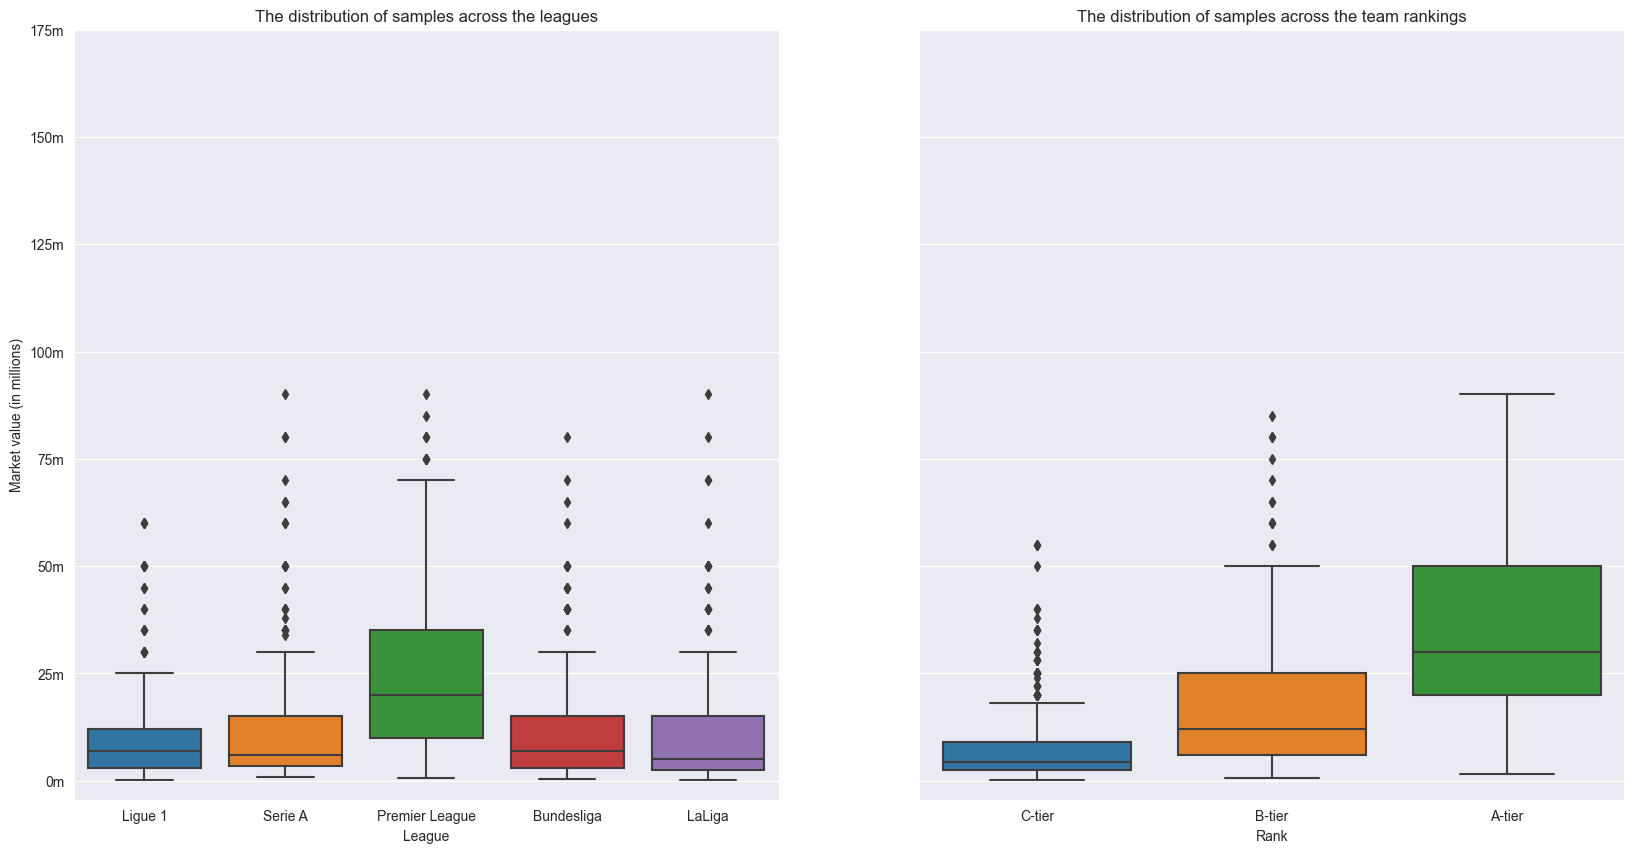

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='League',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Team_rank',
            y='Value',
            order=reversed(order_rank),
            ax=ax[1])

ax[0].set_title('The distribution of samples across the leagues')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of samples across the team rankings')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('')

plt.show()

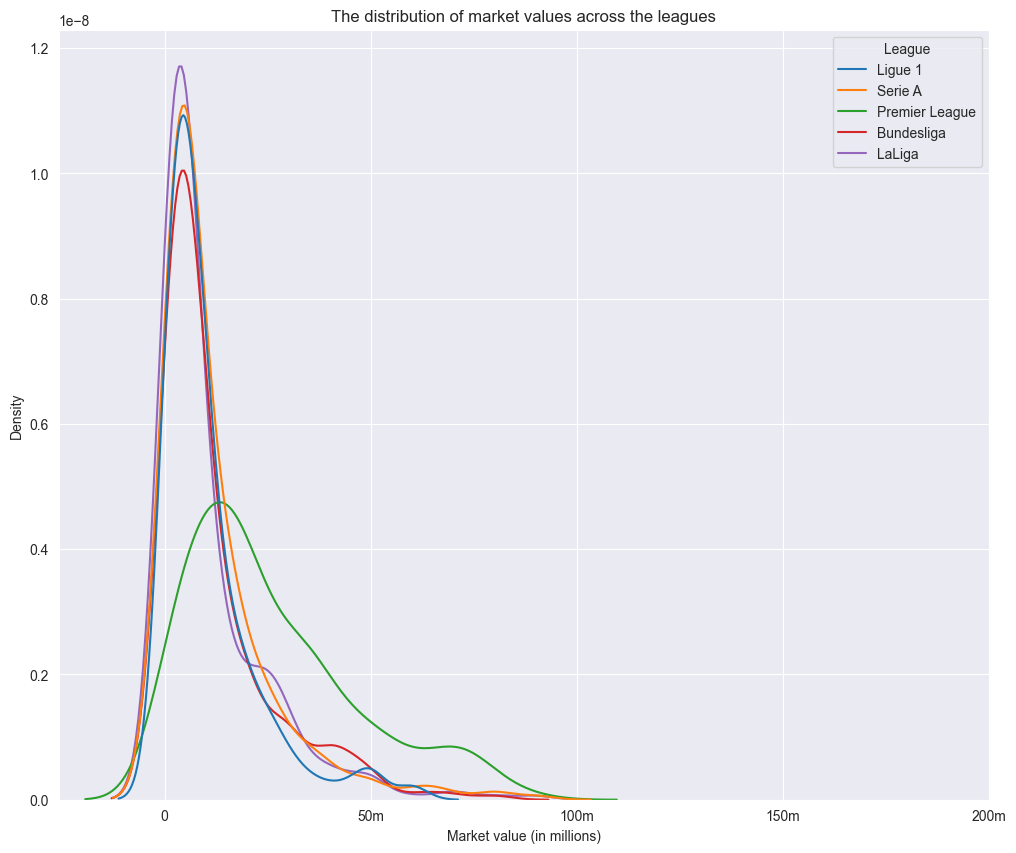

In [33]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='League')

ax.set_title('The distribution of market values across the leagues')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

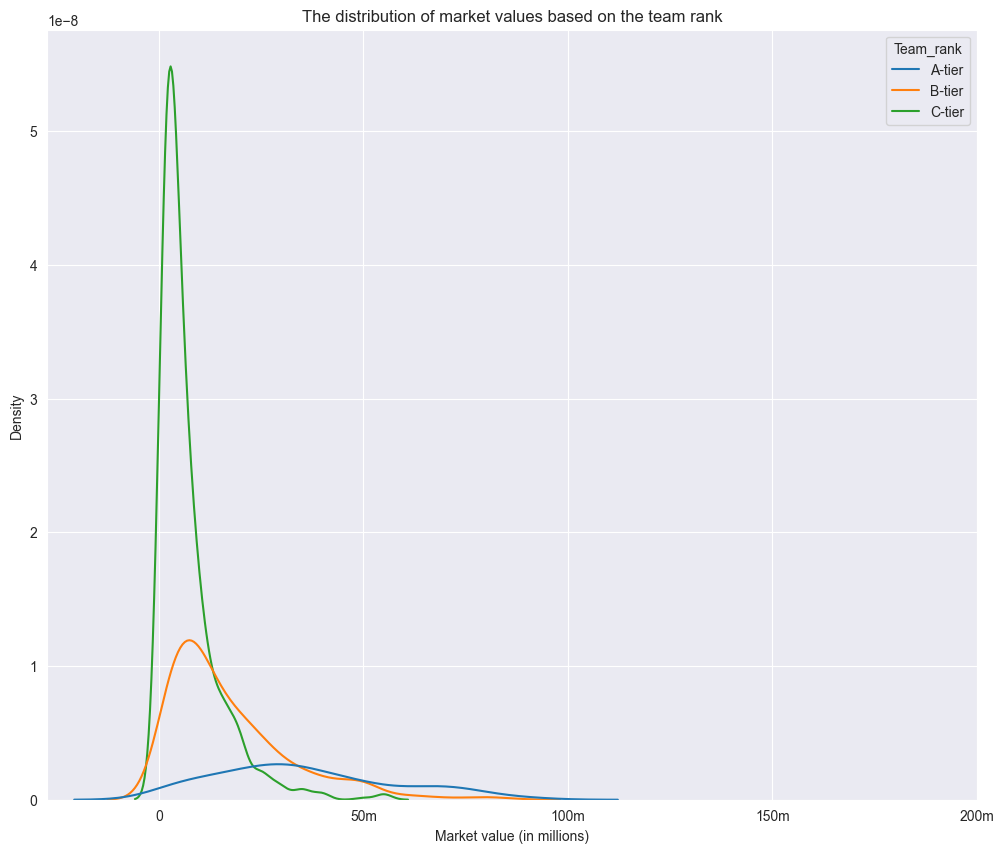

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Team_rank',
            hue_order=order_rank)

ax.set_title('The distribution of market values based on the team rank')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

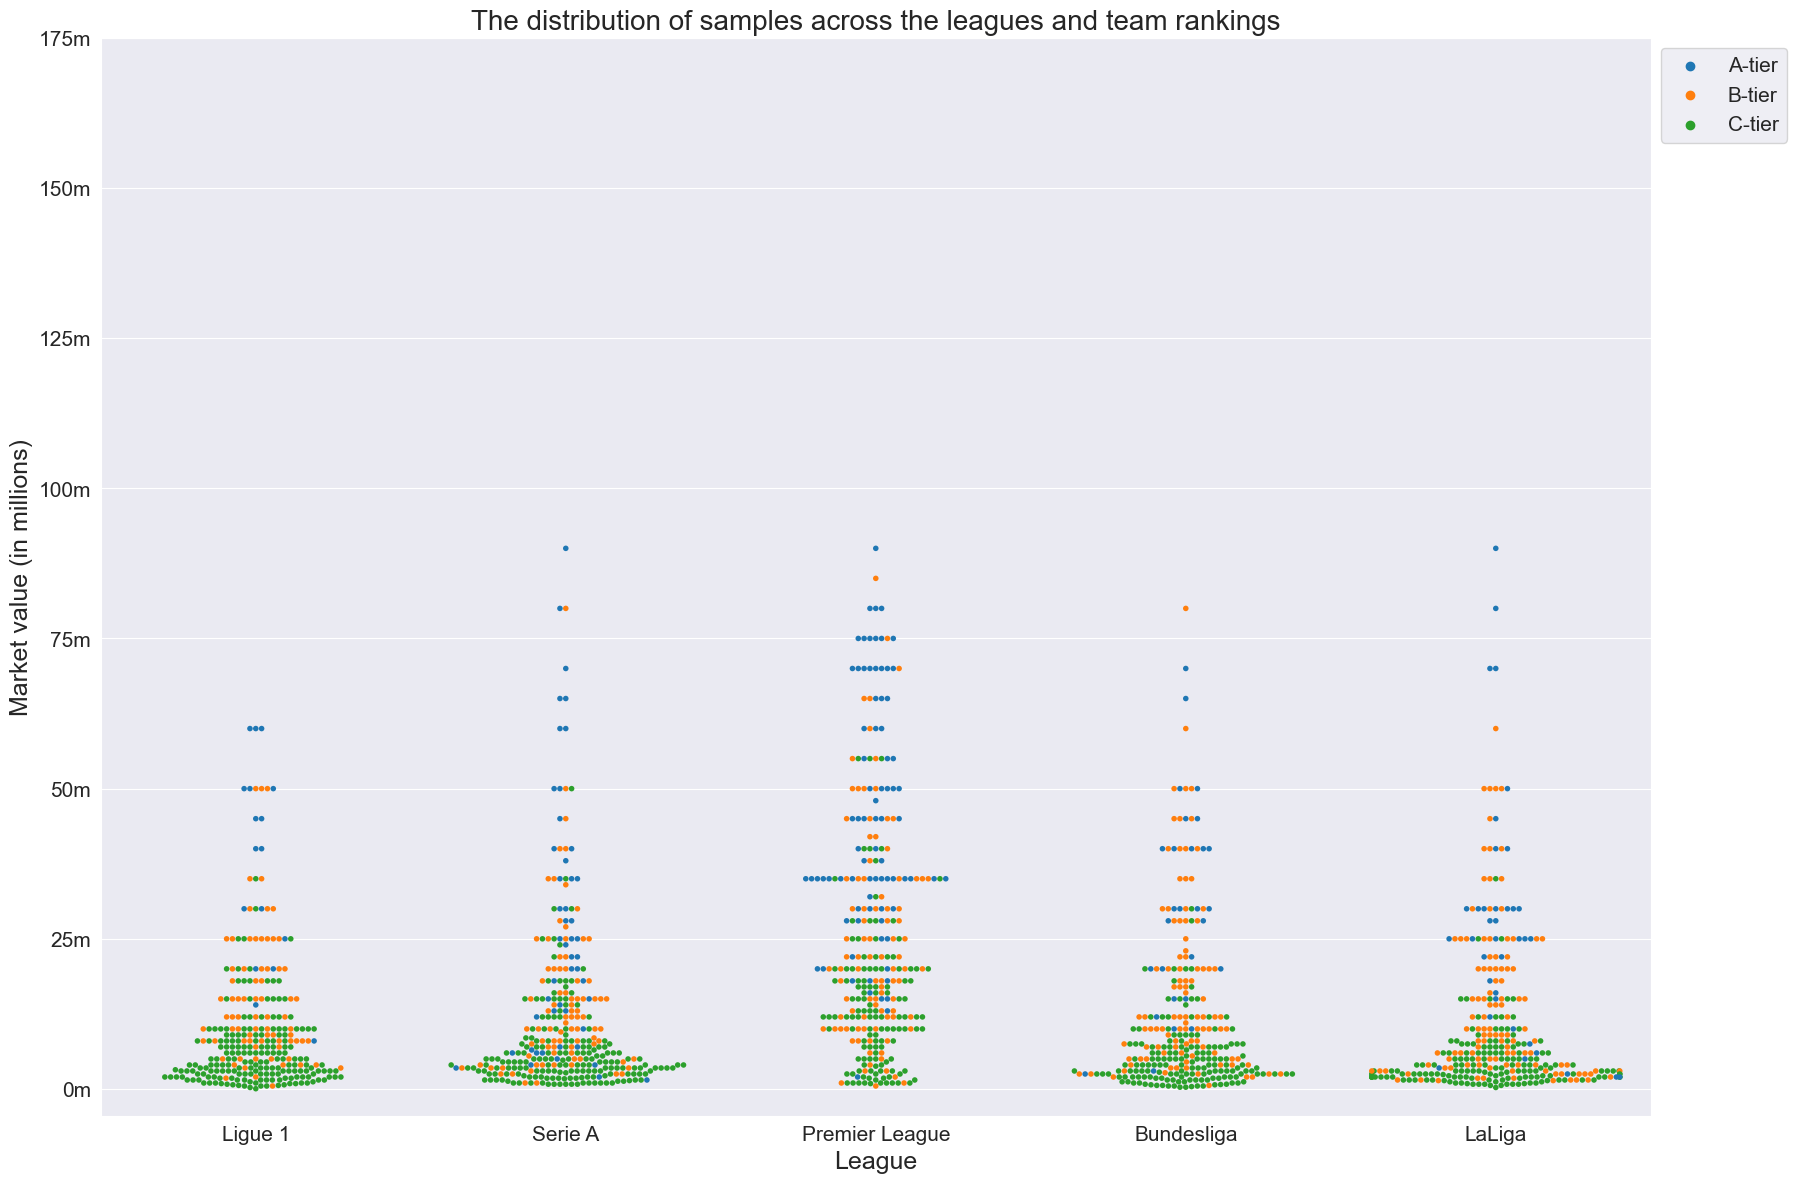

In [35]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.swarmplot(all_data,
              x='League',
              y='Value',
              size=4,
              hue='Team_rank',
              hue_order=order_rank,
              ax=ax)

ax.set_title('The distribution of samples across the leagues and team rankings', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)', fontsize=18)
ax.xaxis.label.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=15)

plt.show()

On the first graph we can see that the distributions are almost the same across the leagues, but the Premier league has a little bit different one with higher market values than for other leagues.

From the second one we can notice that the distributions for A-ranked and B-ranked clubs are more heavy-tailed than for C-ranked teams, and in general, the majority of players in "small clubs" are located on the left part of the graph.

In [31]:
# Creates a table with different descriptive statistics for different groups of a categorical variable 
def descriptive_table(table, variable):
    indices=table.groupby(variable)['Value'].mean().index
    counts = table.groupby(variable)['Value'].count().values
    means = table.groupby(variable)['Value'].mean().values
    stds = table.groupby(variable)['Value'].std().values
    medians = table.groupby(variable)['Value'].median().values
    quantile_ninty = table.groupby(variable)['Value'].quantile(q=0.9).values
    
    table =  pd.DataFrame({'Sample size': counts,
                           'Mean': means,
                           'St. deviation': stds,
                           'Median': medians,
                           '90% quantile': quantile_ninty
                           }, index=indices)
    return table    

In [37]:
for item in ['League', 'Team_rank']:
    print(f"Variable: {item}")
    display(descriptive_table(all_data, item))

Variable: League


Sample size          Mean  St. deviation      Median  \
League                                                                 
Bundesliga              289  1.184446e+07   1.362139e+07   7000000.0   
LaLiga                  311  1.087894e+07   1.367994e+07   5000000.0   
Ligue 1                 282  1.047872e+07   1.155946e+07   7000000.0   
Premier League          300  2.592767e+07   2.059813e+07  20000000.0   
Serie A                 319  1.191505e+07   1.413433e+07   6000000.0   

                90% quantile  
League                        
Bundesliga        30000000.0  
LaLiga            28000000.0  
Ligue 1           25000000.0  
Premier League    55500000.0  
Serie A           28000000.0

Variable: Team_rank


Sample size          Mean  St. deviation      Median  90% quantile
Team_rank                                                                    
A-tier             212  3.553066e+07   2.159779e+07  30000000.0    70000000.0
B-tier             469  1.714136e+07   1.489184e+07  12000000.0    40000000.0
C-tier             820  7.035122e+06   7.529375e+06   4250000.0    17000000.0

**Idea**: We can create a variable that indicates whether some footballer plays in Premier League instead of 'League' column

In [32]:
all_data['From EPL'] = all_data['League'] == 'Premier League'

In [33]:
all_data['Champion'] = all_data['Team'].isin(['Inter', 'Real Madrid', 'Leverkusen', 'Man City', 'PSG'])

Now we will work with positions. It can be very useful to divide player`s positions into four groups (attack, midfield, defence and goalkeeper) because we can expect that the players in attack line cost more than goalkeepers. We will only operate with the main position and create 'Position' column.

In [34]:
position_mapping = {'FW': 'Attack',
                    'AM': 'Midfield',
                    'M': 'Midfield',
                    'DMC': 'Midfield',
                    'D': 'Defence',
                    'GK': 'Goalkeeper'}

all_data['Position'] = all_data['Position_1'].map(position_mapping)

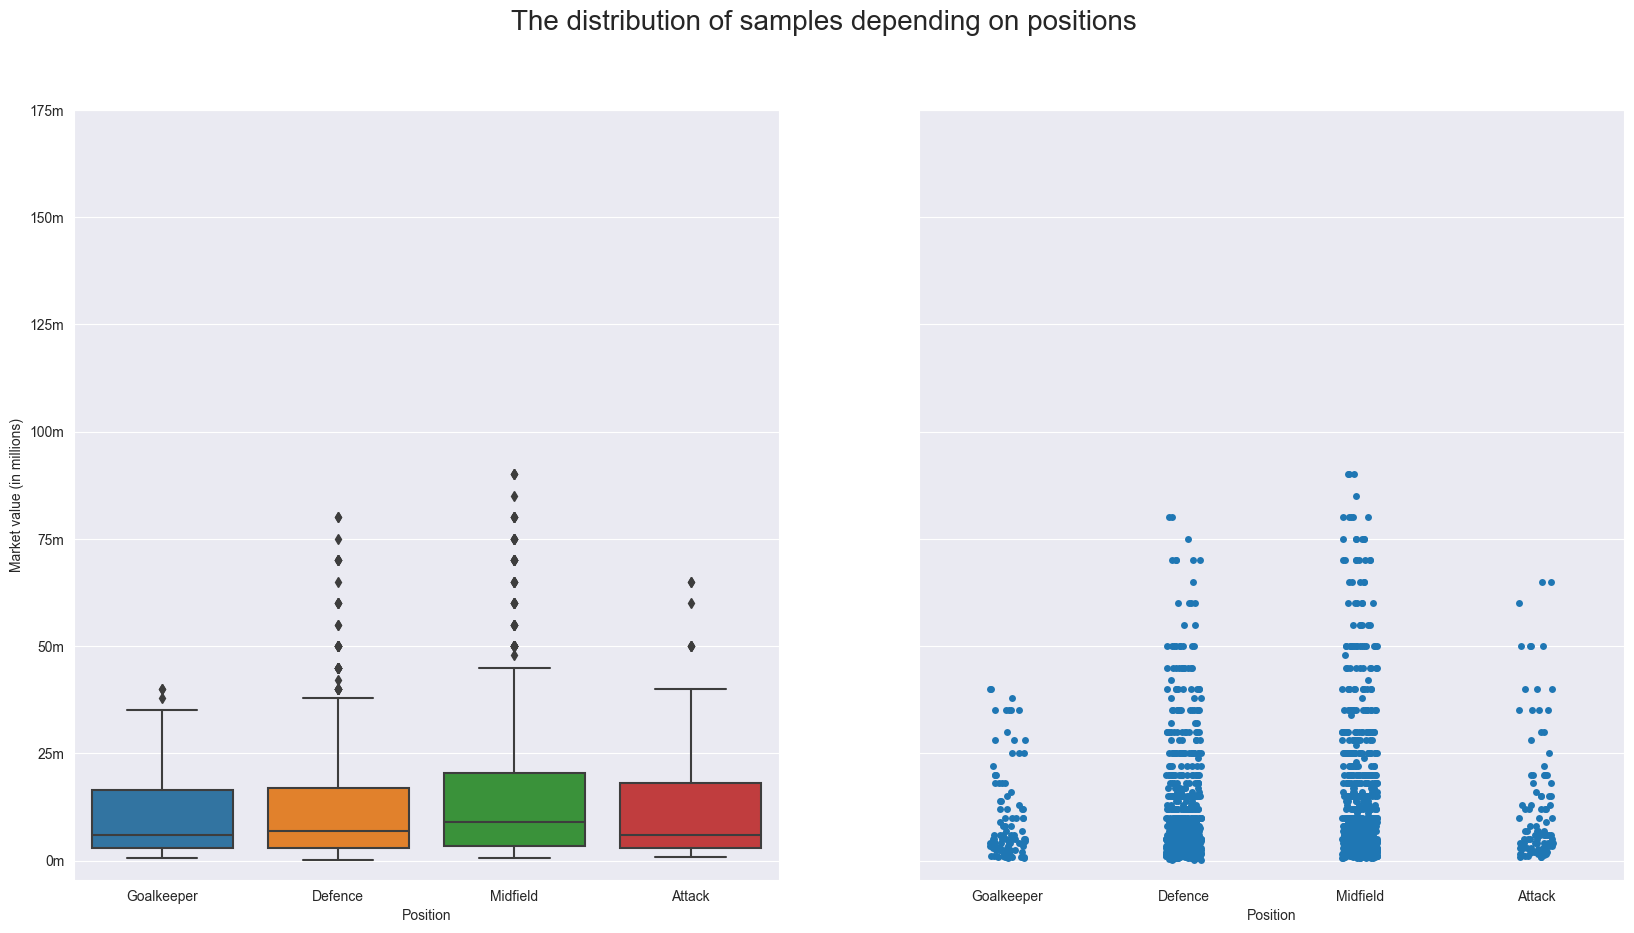

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

position_rank = ['Goalkeeper', 'Defence', 'Midfield', 'Attack']

sns.boxplot(all_data,
            x='Position',
            y='Value',
            order=position_rank,
            ax=ax[0])

sns.stripplot(all_data,
              x='Position',
              y='Value',
              order=position_rank,
              ax=ax[1])

fig.suptitle('The distribution of samples depending on positions', fontsize=20)
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_ylabel('')

plt.show()

In [42]:
display(descriptive_table(all_data, 'Position'))

Sample size          Mean  St. deviation     Median  90% quantile
Position                                                                     
Attack              105  1.315429e+07   1.524639e+07  6000000.0    35000000.0
Defence             604  1.280323e+07   1.449809e+07  7000000.0    35000000.0
Goalkeeper           92  1.098261e+07   1.095287e+07  6000000.0    28000000.0
Midfield            700  1.602264e+07   1.793500e+07  9000000.0    40000000.0

In [43]:
# Significance test for some categorical variable
def significance_test(variable, transformation=False, test_type=None):
    groups = []

    for group in all_data[variable].unique():
        sample = all_data.query(variable + '== @group')['Value'].values
        
        if transformation == 'log': 
            sample = np.log(sample + 1)
        elif transformation == 'sqrt': 
            sample = np.sqrt(np.abs(sample))
            
        print(f'Shapiro-Wilk test: {shapiro(sample)}')
        groups.append(sample)

    print(f'Levene: {levene(*groups)}')
    
    if test_type == 'anova':
        print(f'ANOVA test: {f_oneway(*groups)}')
    elif test_type == 'kruskal':
        for g in groups:
            np.sort(g)
            
        print(f'Kruskal-Wallis test: {kruskal(*groups)}')

In [44]:
significance_test('Position')

Shapiro-Wilk test: ShapiroResult(statistic=0.7712574297463409, pvalue=4.2470250267476395e-30)
Shapiro-Wilk test: ShapiroResult(statistic=0.8179576956414658, pvalue=2.7515947472108494e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.7531810288871987, pvalue=5.385529274485332e-12)
Shapiro-Wilk test: ShapiroResult(statistic=0.7614954246318432, pvalue=1.1835208611674792e-28)
Levene: LeveneResult(statistic=4.853066916766756, pvalue=0.0023046648456136838)


The samples aren`t distributed normally and their variances differ significantly, but we can use transformations

In [45]:
for tr in ['log', 'sqrt']:
    significance_test('Position', transformation=tr)
    print()
    print('=' * 25)
    print()

Shapiro-Wilk test: ShapiroResult(statistic=0.9848174682485364, pvalue=1.1758208701311047e-06)
Shapiro-Wilk test: ShapiroResult(statistic=0.965053164209501, pvalue=0.014381269248892553)
Shapiro-Wilk test: ShapiroResult(statistic=0.9739353071295652, pvalue=0.0362924973643714)
Shapiro-Wilk test: ShapiroResult(statistic=0.9868426443751842, pvalue=2.9165867767681987e-05)
Levene: LeveneResult(statistic=0.11741373771028984, pvalue=0.9499064905282031)


Shapiro-Wilk test: ShapiroResult(statistic=0.9222498707835982, pvalue=1.581346951807626e-18)
Shapiro-Wilk test: ShapiroResult(statistic=0.9249852283966152, pvalue=5.364401075761995e-05)
Shapiro-Wilk test: ShapiroResult(statistic=0.8929512396820222, pvalue=3.952568194290372e-07)
Shapiro-Wilk test: ShapiroResult(statistic=0.9196966107895024, pvalue=2.1526076037501345e-17)
Levene: LeveneResult(statistic=3.1312330080651085, pvalue=0.024783820889937302)




The samples` distribution is still abnormal, but their variances are homogenous, so we can try to use Kruskal-Wallis test (we cannot use ANOVA test)

In [46]:
print('Without transformation: ')
significance_test('Position', transformation=False, test_type='kruskal')

Without transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.7712574297463409, pvalue=4.2470250267476395e-30)
Shapiro-Wilk test: ShapiroResult(statistic=0.8179576956414658, pvalue=2.7515947472108494e-09)
Shapiro-Wilk test: ShapiroResult(statistic=0.7531810288871987, pvalue=5.385529274485332e-12)
Shapiro-Wilk test: ShapiroResult(statistic=0.7614954246318432, pvalue=1.1835208611674792e-28)
Levene: LeveneResult(statistic=4.853066916766756, pvalue=0.0023046648456136838)
Kruskal-Wallis test: KruskalResult(statistic=13.372199842182956, pvalue=0.003897090212298734)


In [47]:
print('With log transformation: ')
significance_test('Position', transformation='log', test_type='kruskal')

With log transformation: 
Shapiro-Wilk test: ShapiroResult(statistic=0.9848174682485364, pvalue=1.1758208701311047e-06)
Shapiro-Wilk test: ShapiroResult(statistic=0.965053164209501, pvalue=0.014381269248892553)
Shapiro-Wilk test: ShapiroResult(statistic=0.9739353071295652, pvalue=0.0362924973643714)
Shapiro-Wilk test: ShapiroResult(statistic=0.9868426443751842, pvalue=2.9165867767681987e-05)
Levene: LeveneResult(statistic=0.11741373771028984, pvalue=0.9499064905282031)
Kruskal-Wallis test: KruskalResult(statistic=13.372199842182956, pvalue=0.003897090212298734)


Since Kruskal-Wallis test shows significant result, we can leave this variable

Let`s check 'Side_11' variable because it is footballer's main side (location where he usually plays)

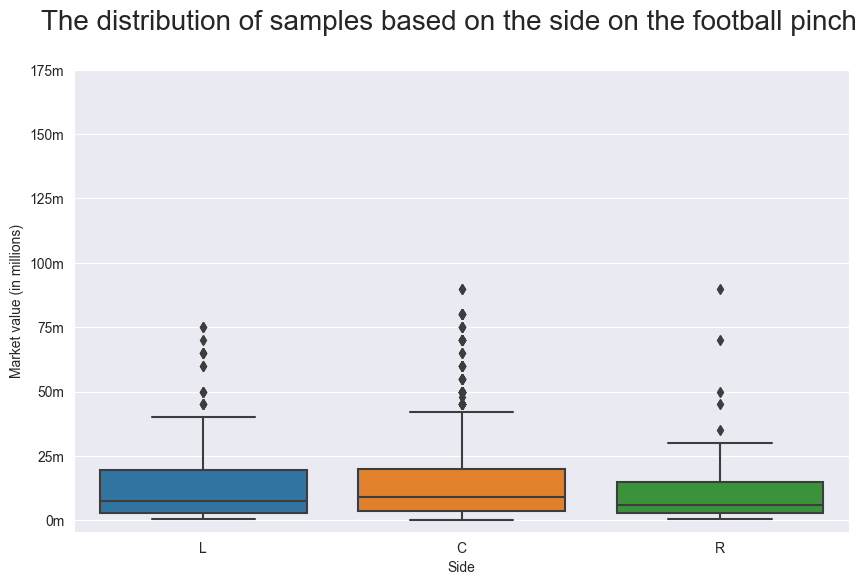

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

side_rank = ['L', 'C', 'R']

sns.boxplot(all_data,
            x='Side_11',
            y='Value',
            order=side_rank,
            ax=ax)

fig.suptitle('The distribution of samples based on the side on the football pinch', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')
ax.set_xlabel('Side')

plt.show()

In [49]:
descriptive_table(all_data, 'Side_11')

Sample size          Mean  St. deviation     Median  90% quantile
Side_11                                                                   
C                850  1.538835e+07   1.711831e+07  9000000.0    40000000.0
L                234  1.351068e+07   1.555355e+07  7500000.0    35000000.0
R                113  1.102832e+07   1.348603e+07  6000000.0    25000000.0

In [35]:
all_data['Side_11'].fillna(all_data['Side_11'].mode().values[0], inplace=True)
#all_data['Side_11'] = all_data.groupby('Position')['Side_11'].transform(lambda x: x.fillna(x.mode()))

In [36]:
all_data.rename(columns={'Side_11': 'Main side'}, inplace=True)

This variable is not so useful as the previous ones. There are too little data for Left and Right sides, and we can expect that 'Side_12', 'Side_13', etc. are even less informative, so in the future we can drop them, leaving only 'Main_side' (it is the same as 'Side_11') variable.

Now we will work with 'Position_1_Sides' and 'Position_2_Sides' and create some interesting (at least we hope) plots

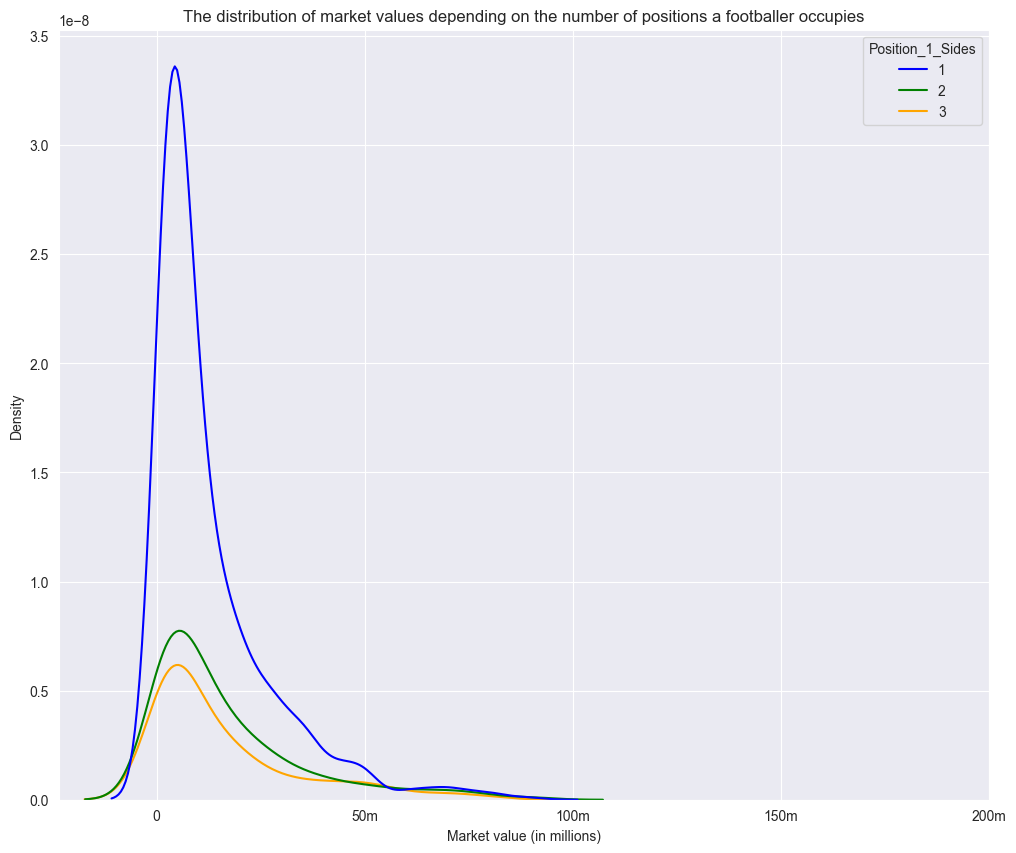

In [52]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Position_1_Sides',
            palette=['blue', 'green', 'orange'])

ax.set_title('The distribution of market values depending on the number of positions a footballer occupies')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

Now let`s work with numerical variables  

In [53]:
all_data.describe()

Age         Mins        Goals      Assists          Yel  \
count  1501.000000  1501.000000  1501.000000  1501.000000  1501.000000   
mean     26.778148  1908.514990     2.656229     1.911392     3.950033   
std       4.029981   706.974901     3.507574     2.198669     2.689641   
min      16.000000   195.000000     0.000000     0.000000     0.000000   
25%      24.000000  1366.000000     0.000000     0.000000     2.000000   
50%      26.000000  1893.000000     1.000000     1.000000     4.000000   
75%      30.000000  2470.000000     4.000000     3.000000     5.000000   
max      40.000000  3420.000000    28.000000    14.000000    17.000000   

               Red          SpG           PS   AerialsWon         MotM  ...  \
count  1501.000000  1501.000000  1501.000000  1501.000000  1501.000000  ...   
mean      0.172552     0.868155    79.890606     0.966422     0.970020  ...   
std       0.413368     0.654318     7.913073     0.854396     1.358345  ...   
min       0.000000     0.000000    44.900000     0.000000     0.000000  ...   
25%       0.000000     0.400000    75.600000     0.400000     0.000000  ...   
50%       0.000000     0.700000    81.000000     0.700000     1.000000  ...   
75%       0.000000     1.200000    85.500000     1.300000     1.000000  ...   
max       3.000000     3.800000    95.400000     6.800000    10.000000  ...   

           Crosses        LongB         ThrB  Clean Sheets %   Popularity  \
count  1501.000000  1501.000000  1501.000000     1501.000000  1501.000000   
mean      0.300866     1.629181     0.037975        0.015602     1.180688   
std       0.414768     1.656253     0.066310        0.067817     0.536418   
min       0.000000     0.000000     0.000000        0.000000     0.212000   
25%       0.000000     0.500000     0.000000        0.000000     1.000000   
50%       0.100000     1.100000     0.000000        0.000000     1.000000   
75%       0.400000     2.200000     0.100000        0.000000     1.000000   
max       2.900000    15.400000     0.500000        0.559000     4.000000   

       Overall_Apps   Start_Apps         Value  Position_1_Sides  \
count   1501.000000  1501.000000  1.501000e+03       1501.000000   
mean      17.303131     7.189207  1.421759e+07          1.556296   
std        9.539220     5.543781  1.615040e+07          0.764414   
min        0.000000     1.000000  5.000000e+04          1.000000   
25%       10.000000     3.000000  3.000000e+06          1.000000   
50%       18.000000     5.000000  8.000000e+06          1.000000   
75%       25.000000    11.000000  2.000000e+07          2.000000   
max       37.000000    28.000000  9.000000e+07          3.000000   

       Position_2_Sides  
count       1501.000000  
mean           1.078614  
std            0.329367  
min            1.000000  
25%            1.000000  
50%            1.000000  
75%            1.000000  
max            3.000000  

[8 rows x 36 columns]

In [54]:
df_train, df_test = divide_df(all_data)

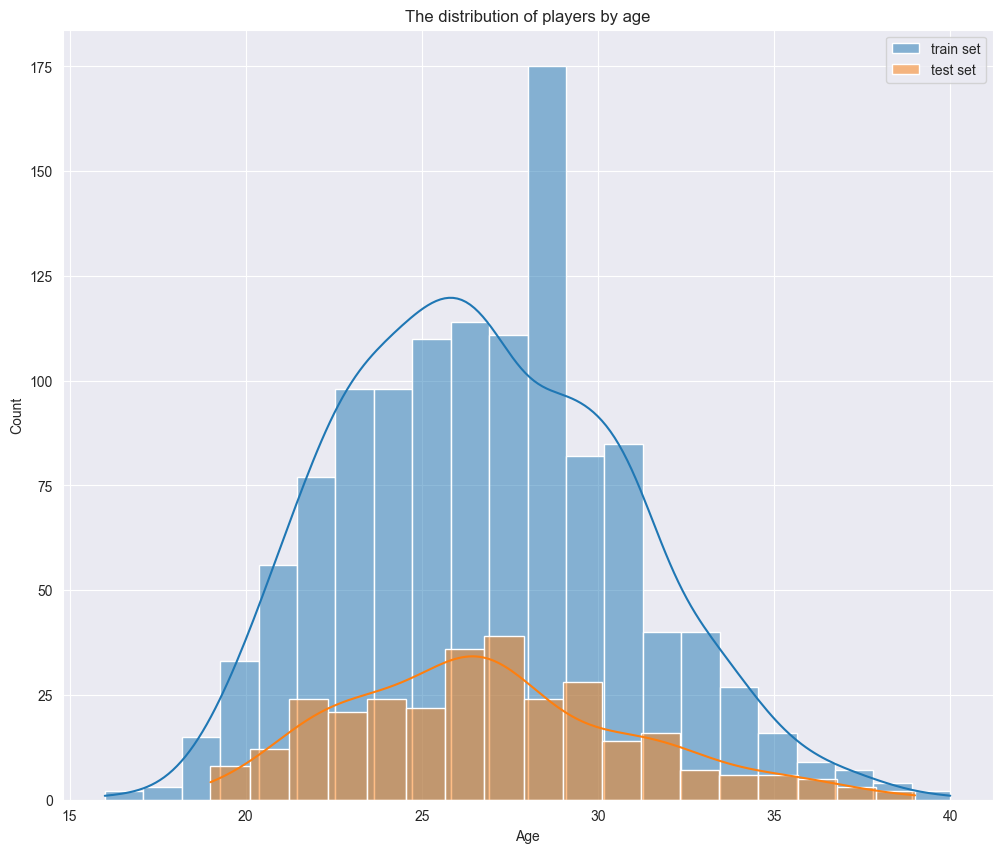

In [55]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Age',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Age',
            kde=True,
            bins=18,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by age')
ax.set_xlabel('Age')
ax.legend()

plt.show()

In [56]:
#all_data['Age'] = pd.cut(all_data['Age'], bins=4)

In [37]:
all_data['Very old'] = all_data['Age'] >= 32

In [38]:
df_train, df_test = divide_df(all_data)

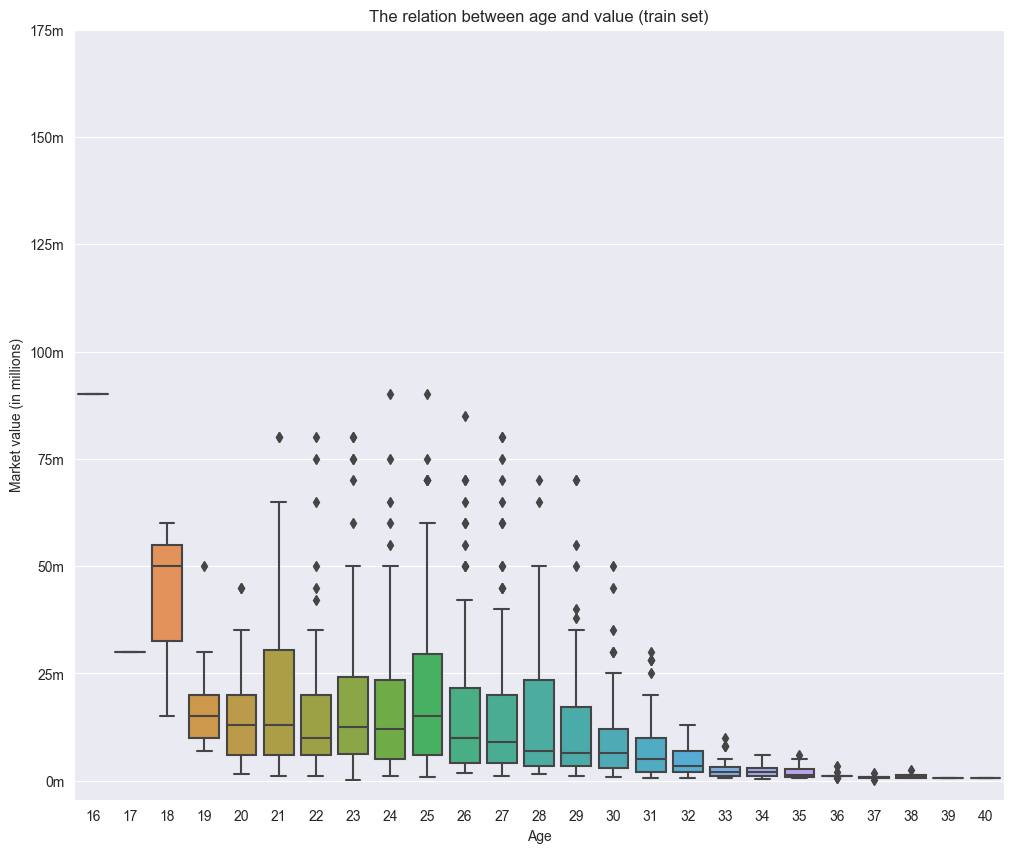

In [59]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Age',
            y='Value',
            ax=ax)

ax.set_title('The relation between age and value (train set)')
ax.set_xlabel('Age')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [60]:
descriptive_table(df_train, 'Age')

Sample size          Mean  St. deviation      Median  90% quantile
Age                                                                    
16             1  9.000000e+07            NaN  90000000.0    90000000.0
17             1  3.000000e+07            NaN  30000000.0    30000000.0
18             3  4.166667e+07   2.362908e+07  50000000.0    58000000.0
19            15  1.773333e+07   1.132927e+07  15000000.0    29200000.0
20            33  1.562121e+07   1.177791e+07  13000000.0    30000000.0
21            56  2.055357e+07   1.959492e+07  13000000.0    47500000.0
22            77  1.599481e+07   1.596661e+07  10000000.0    35000000.0
23            98  1.922296e+07   1.884589e+07  12500000.0    48600000.0
24            98  1.745000e+07   1.702033e+07  12000000.0    40000000.0
25           110  2.067273e+07   1.929628e+07  15000000.0    45000000.0
26           114  1.719298e+07   1.774845e+07  10000000.0    40000000.0
27           111  1.641712e+07   1.849116e+07   9000000.0    45000000.0
28            79  1.490886e+07   1.607219e+07   7000000.0    40000000.0
29            96  1.273542e+07   1.430854e+07   6500000.0    30000000.0
30            82  9.731707e+06   9.952242e+06   6500000.0    22000000.0
31            85  7.155882e+06   6.949809e+06   5000000.0    15600000.0
32            40  4.620000e+06   3.388381e+06   3500000.0    10000000.0
33            40  2.675000e+06   2.324204e+06   1900000.0     5300000.0
34            27  2.166667e+06   1.360430e+06   2000000.0     4000000.0
35            16  1.887500e+06   1.683597e+06   1250000.0     4250000.0
36             9  1.288889e+06   9.293068e+05   1000000.0     2300000.0
37             7  8.214286e+05   4.742161e+05    800000.0     1200000.0
38             4  1.200000e+06   8.906926e+05    900000.0     2050000.0
39             1  5.000000e+05            NaN    500000.0      500000.0
40             1  5.000000e+05            NaN    500000.0      500000.0

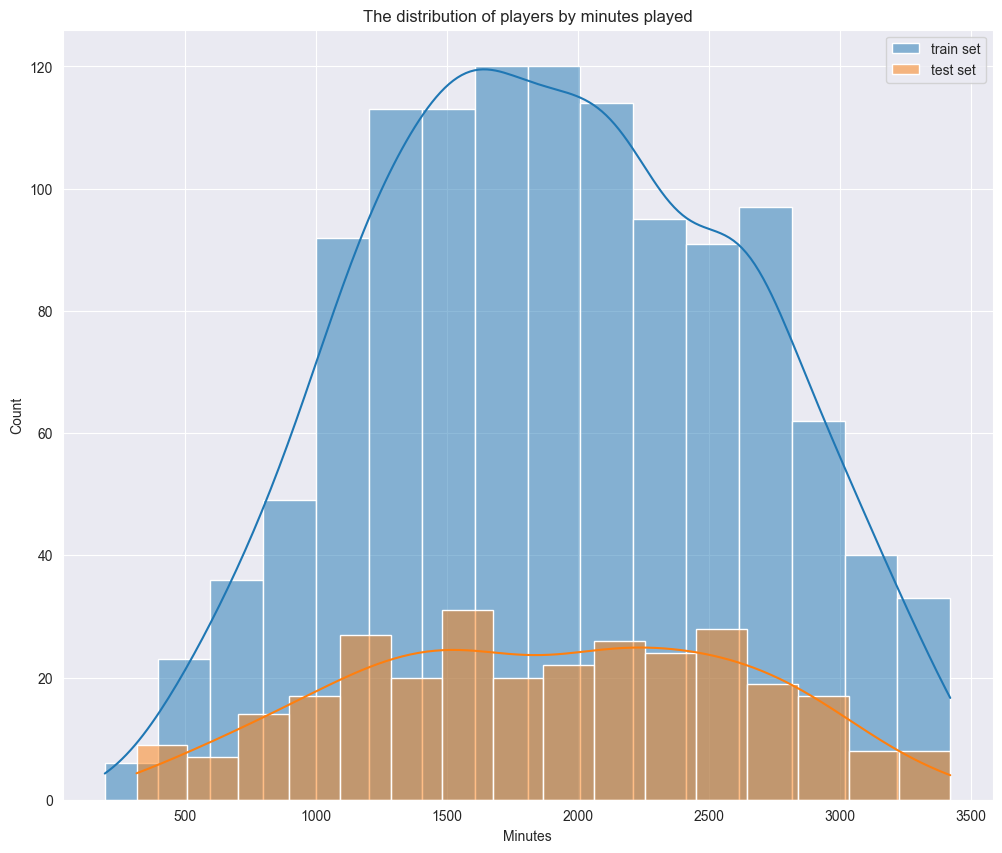

In [61]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Mins',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Mins',
            kde=True,
            bins=16,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by minutes played')
ax.set_xlabel('Minutes')
ax.legend()

plt.show()

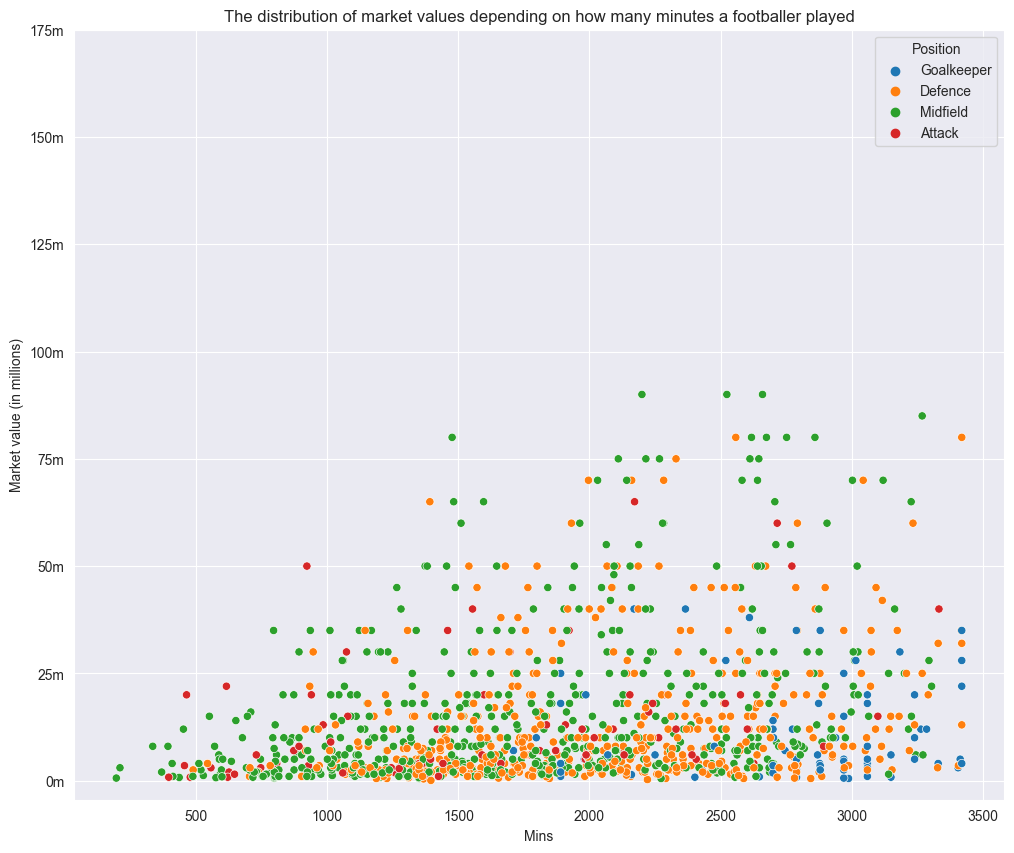

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(df_train,
            x='Mins',
            y='Value',
            hue='Position',
            hue_order=position_rank,
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

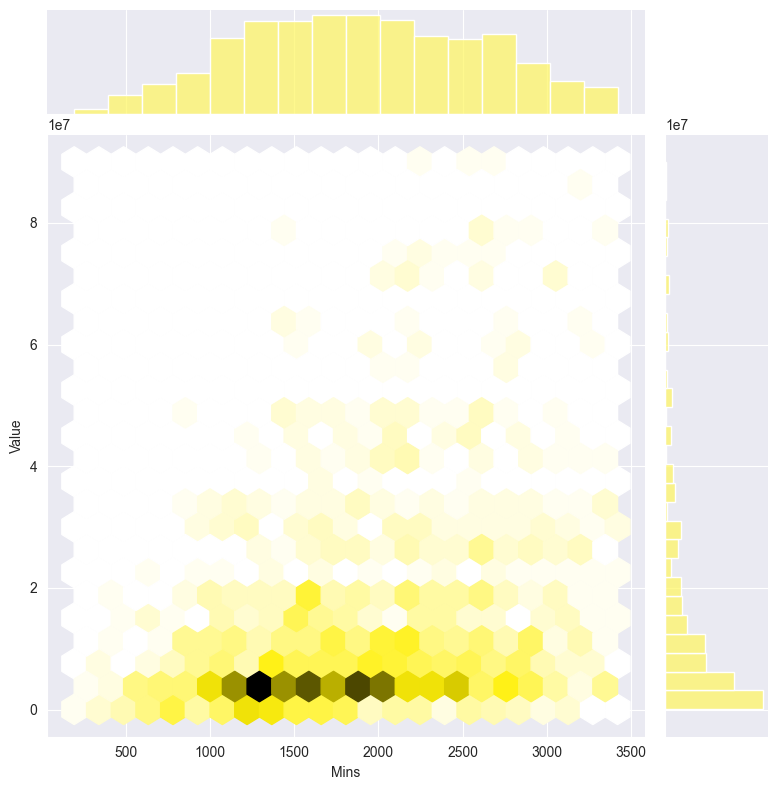

In [63]:
sns.jointplot(df_train,
              x='Mins',
              y='Value',
              kind="hex", 
              height=8,
              color="#FFF668")

plt.show()

In [64]:
#all_data['Minutes for MotM'] = all_data['Mins'] / all_data['MotM']
#all_data['Minutes for Goal'] = all_data['Mins'] / all_data['Goals']
#all_data['Minutes for Assist'] = all_data['Mins'] / all_data['Assists']
#all_data['Minutes for KeyP'] = all_data['Mins'] / all_data['KeyP']

In [39]:
#all_data['Mins'] = pd.qcut(all_data['Mins'], q=4)
df_train, df_test = divide_df(all_data)

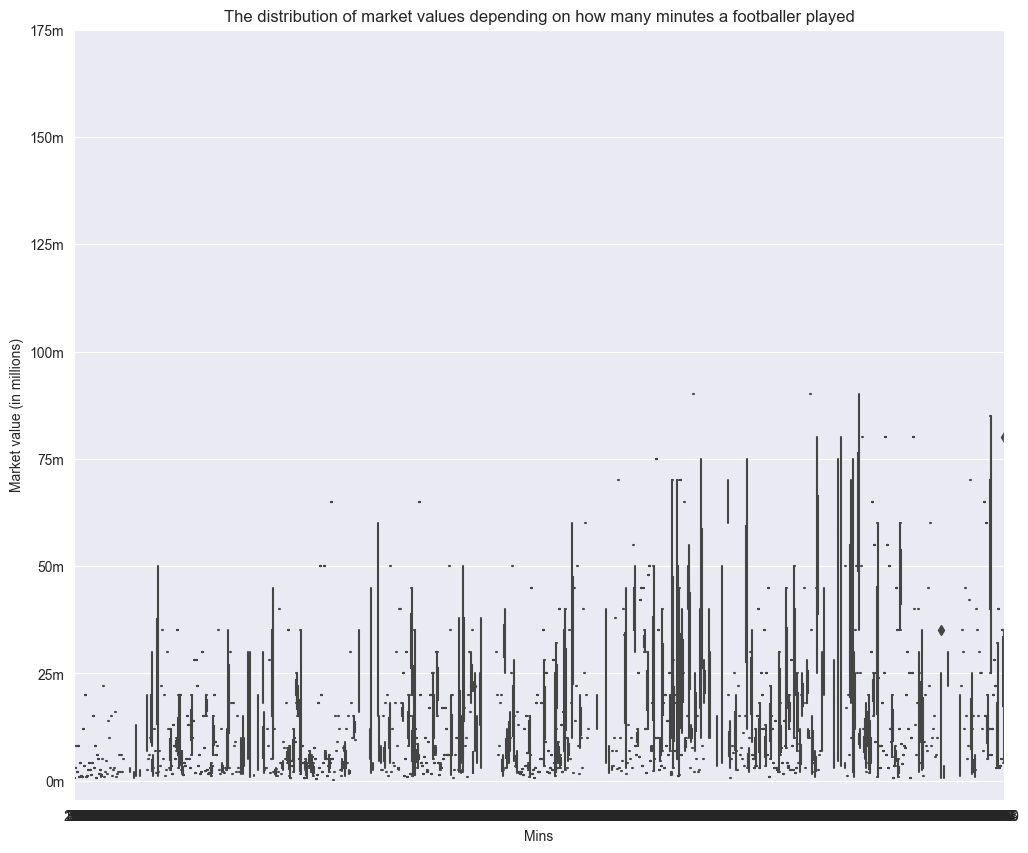

In [66]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Mins',
            y='Value',
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [67]:
descriptive_table(df_train, 'Mins')

Sample size          Mean  St. deviation      Median  90% quantile
Mins                                                                    
195             1  6.000000e+05            NaN    600000.0      600000.0
209             1  3.000000e+06            NaN   3000000.0     3000000.0
334             1  8.000000e+06            NaN   8000000.0     8000000.0
368             1  2.000000e+06            NaN   2000000.0     2000000.0
392             1  8.000000e+06            NaN   8000000.0     8000000.0
...           ...           ...            ...         ...           ...
3406            1  3.000000e+06            NaN   3000000.0     3000000.0
3407            1  3.500000e+06            NaN   3500000.0     3500000.0
3414            1  5.000000e+06            NaN   5000000.0     5000000.0
3418            1  3.500000e+07            NaN  35000000.0    35000000.0
3420            7  3.057143e+07   2.435746e+07  28000000.0    53000000.0

[938 rows x 5 columns]

In [40]:
all_data['Goals'] = pd.cut(all_data['Goals'], bins=4)
all_data['Assists'] = pd.cut(all_data['Assists'], bins=4)

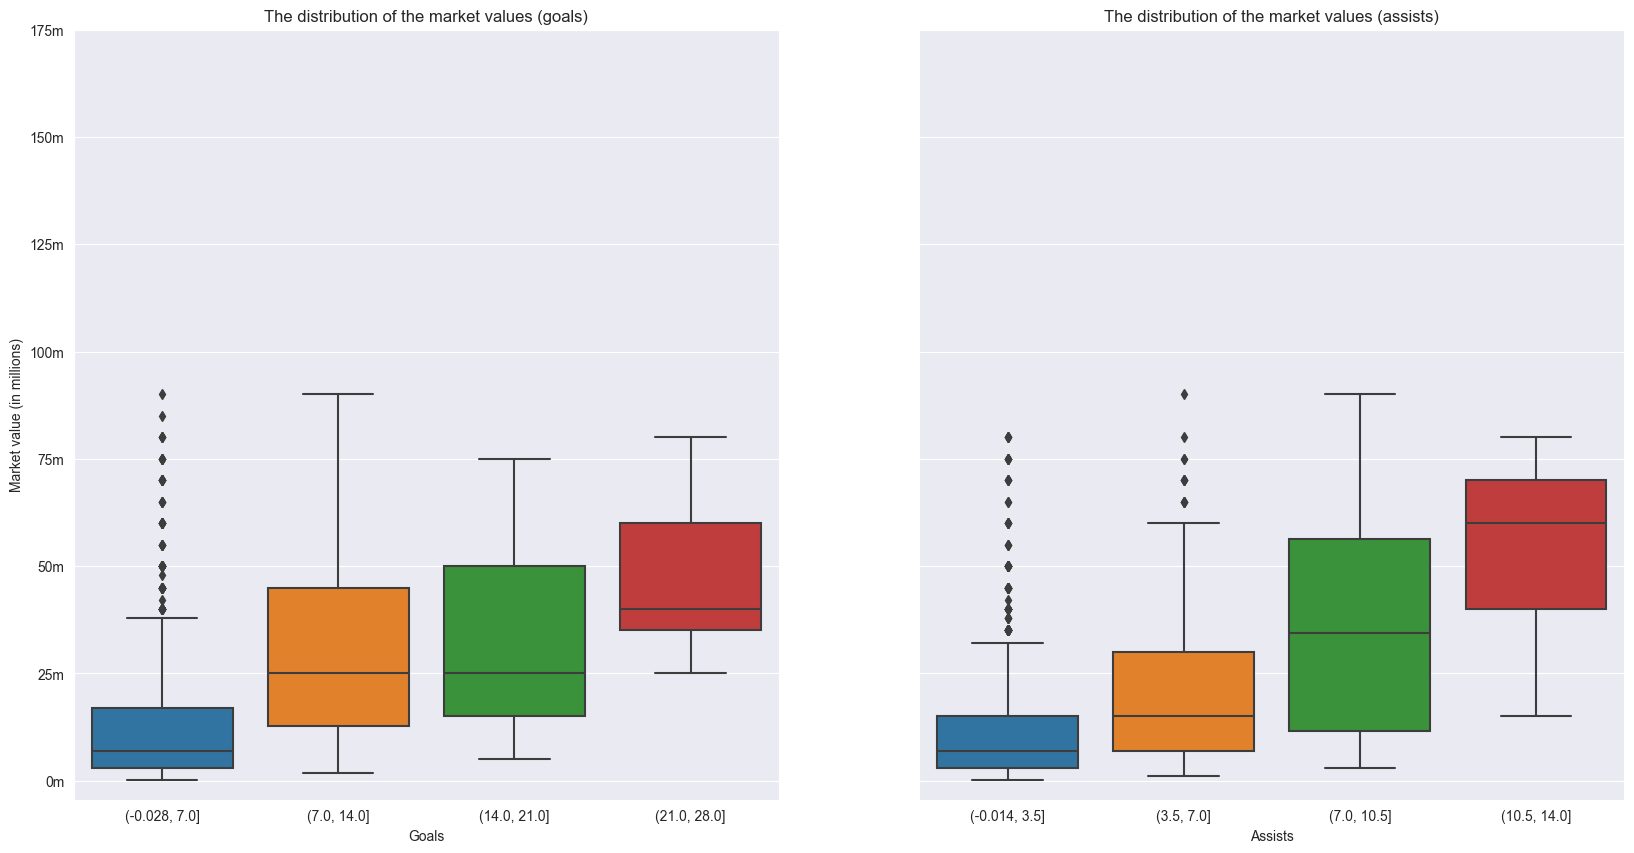

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='Goals',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Assists',
            y='Value',
            ax=ax[1])

ax[0].set_title('The distribution of the market values (goals)')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of the market values (assists)')
ax[1].set_ylabel('')

plt.show()

In [70]:
for item in ['Goals', 'Assists']:
    print(f'Variable: {item}')
    display(descriptive_table(all_data, item))

Variable: Goals


Sample size          Mean  St. deviation      Median  \
Goals                                                                 
(-0.028, 7.0]         1371  1.256003e+07   1.444838e+07   7000000.0   
(7.0, 14.0]            108  3.110000e+07   2.163321e+07  25000000.0   
(14.0, 21.0]            17  3.070588e+07   2.287948e+07  25000000.0   
(21.0, 28.0]             5  4.800000e+07   2.196588e+07  40000000.0   

               90% quantile  
Goals                        
(-0.028, 7.0]    30000000.0  
(7.0, 14.0]      65000000.0  
(14.0, 21.0]     65000000.0  
(21.0, 28.0]     72000000.0

Variable: Assists


Sample size          Mean  St. deviation      Median  \
Assists                                                               
(-0.014, 3.5]         1243  1.177474e+07   1.338832e+07   7000000.0   
(3.5, 7.0]             209  2.260096e+07   1.964714e+07  15000000.0   
(7.0, 10.5]             40  3.715000e+07   2.605571e+07  34500000.0   
(10.5, 14.0]             9  5.500000e+07   2.165064e+07  60000000.0   

               90% quantile  
Assists                      
(-0.014, 3.5]    30000000.0  
(3.5, 7.0]       50000000.0  
(7.0, 10.5]      70000000.0  
(10.5, 14.0]     80000000.0

Let`s drop redundant features or the features with missing values

In [41]:
all_data.drop(['Side_12', 'Side_13', 'Side_21', 'Side_22', 'League', 'Team',
               'Side_23', 'Position_1', 'Position_2', 'Position_2_Sides'], axis=1, inplace=True)

all_data, all_names = all_data.drop('Name', axis=1), all_data['Name']

train_names, test_names = divide_df(all_names) 

In [72]:
all_data.sample(10)

Age  Mins          Goals        Assists  Yel  Red  SpG    PS  \
332    34  1468  (-0.028, 7.0]  (-0.014, 3.5]    0    0  1.1  84.5   
571    29  1974  (-0.028, 7.0]  (-0.014, 3.5]    8    0  1.5  84.1   
1160   31  1797  (-0.028, 7.0]  (-0.014, 3.5]    1    0  0.0  52.9   
154    24  1043  (-0.028, 7.0]  (-0.014, 3.5]    0    0  0.6  82.8   
306    36  2387  (-0.028, 7.0]  (-0.014, 3.5]    1    0  0.5  91.1   
1129   25  1715  (-0.028, 7.0]  (-0.014, 3.5]    6    1  0.6  90.0   
718    23  2141  (-0.028, 7.0]  (-0.014, 3.5]    3    1  0.5  81.7   
401    28  2787    (7.0, 14.0]   (10.5, 14.0]    1    0  2.2  87.2   
509    25  2295  (-0.028, 7.0]  (-0.014, 3.5]    6    1  0.7  88.9   
1524   24  2754  (-0.028, 7.0]  (-0.014, 3.5]    5    0  0.6  81.6   

      AerialsWon  MotM  ...  Main side     Value  Position_1_Sides  Team_rank  \
332          0.2     2  ...          C   3500000                 3     B-tier   
571          0.4     5  ...          C  20000000                 2     B-tier   
1160         0.1     2  ...          C  10000000                 1     C-tier   
154          0.0     0  ...          C   3000000                 3     B-tier   
306          2.4     1  ...          C   3500000                 1     A-tier   
1129         1.5     0  ...          C  15000000                 1     B-tier   
718          1.3     1  ...          R   2000000                 1     C-tier   
401          0.4     7  ...          L  45000000                 1     B-tier   
509          1.9     2  ...          C   8000000                 1     C-tier   
1524         0.7     0  ...          L   5000000                 1     C-tier   

      European tournament  Out of top5  From EPL  Champion    Position  \
332     Conference League        False     False     False    Midfield   
571      Champions League        False     False     False    Midfield   
1160                 None        False      True     False  Goalkeeper   
154         Europa League        False     False     False    Midfield   
306      Champions League        False     False      True     Defence   
1129                 None        False     False     False     Defence   
718                  None        False     False     False     Defence   
401         Europa League        False     False      True     Defence   
509                  None        False     False     False     Defence   
1524                 None        False     False     False     Defence   

      Very old  
332       True  
571      False  
1160     False  
154      False  
306       True  
1129     False  
718      False  
401      False  
509      False  
1524     False  

[10 rows x 43 columns]

In [73]:
def pairplot_creator(table, index_start=0, index_end=40):
    new_table = table.iloc[:, index_start:index_end]
    new_table['Value'] = table['Value']
    
    sns.pairplot(new_table, height=2)
    plt.show()

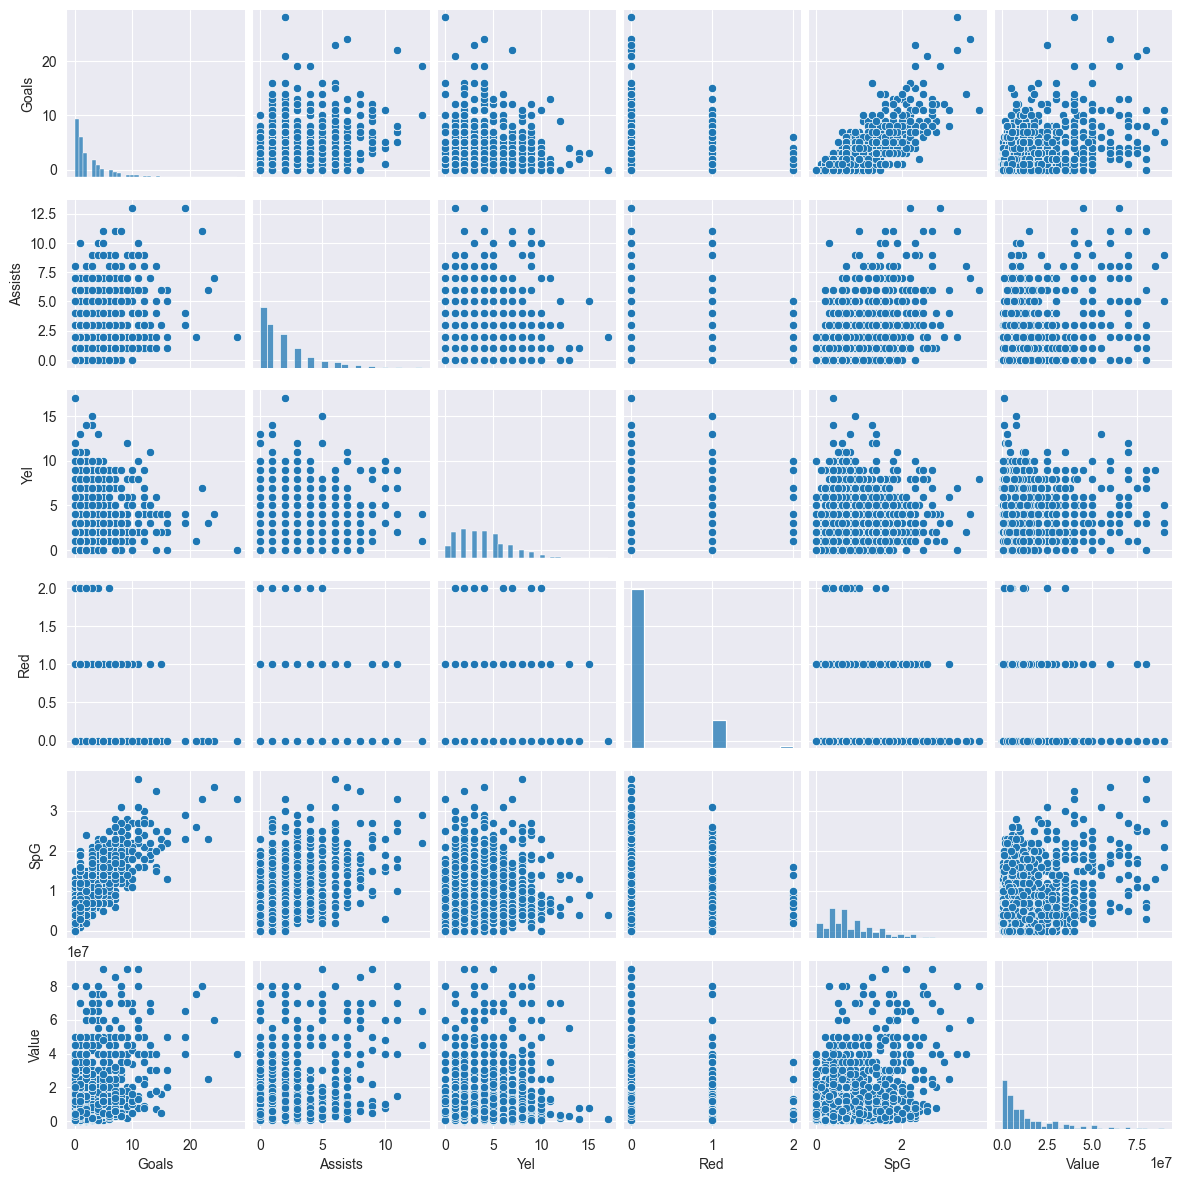

In [74]:
pairplot_creator(df_train, index_start=4, index_end=9)

In [42]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

In [43]:
df_train, df_test = divide_df(all_data)

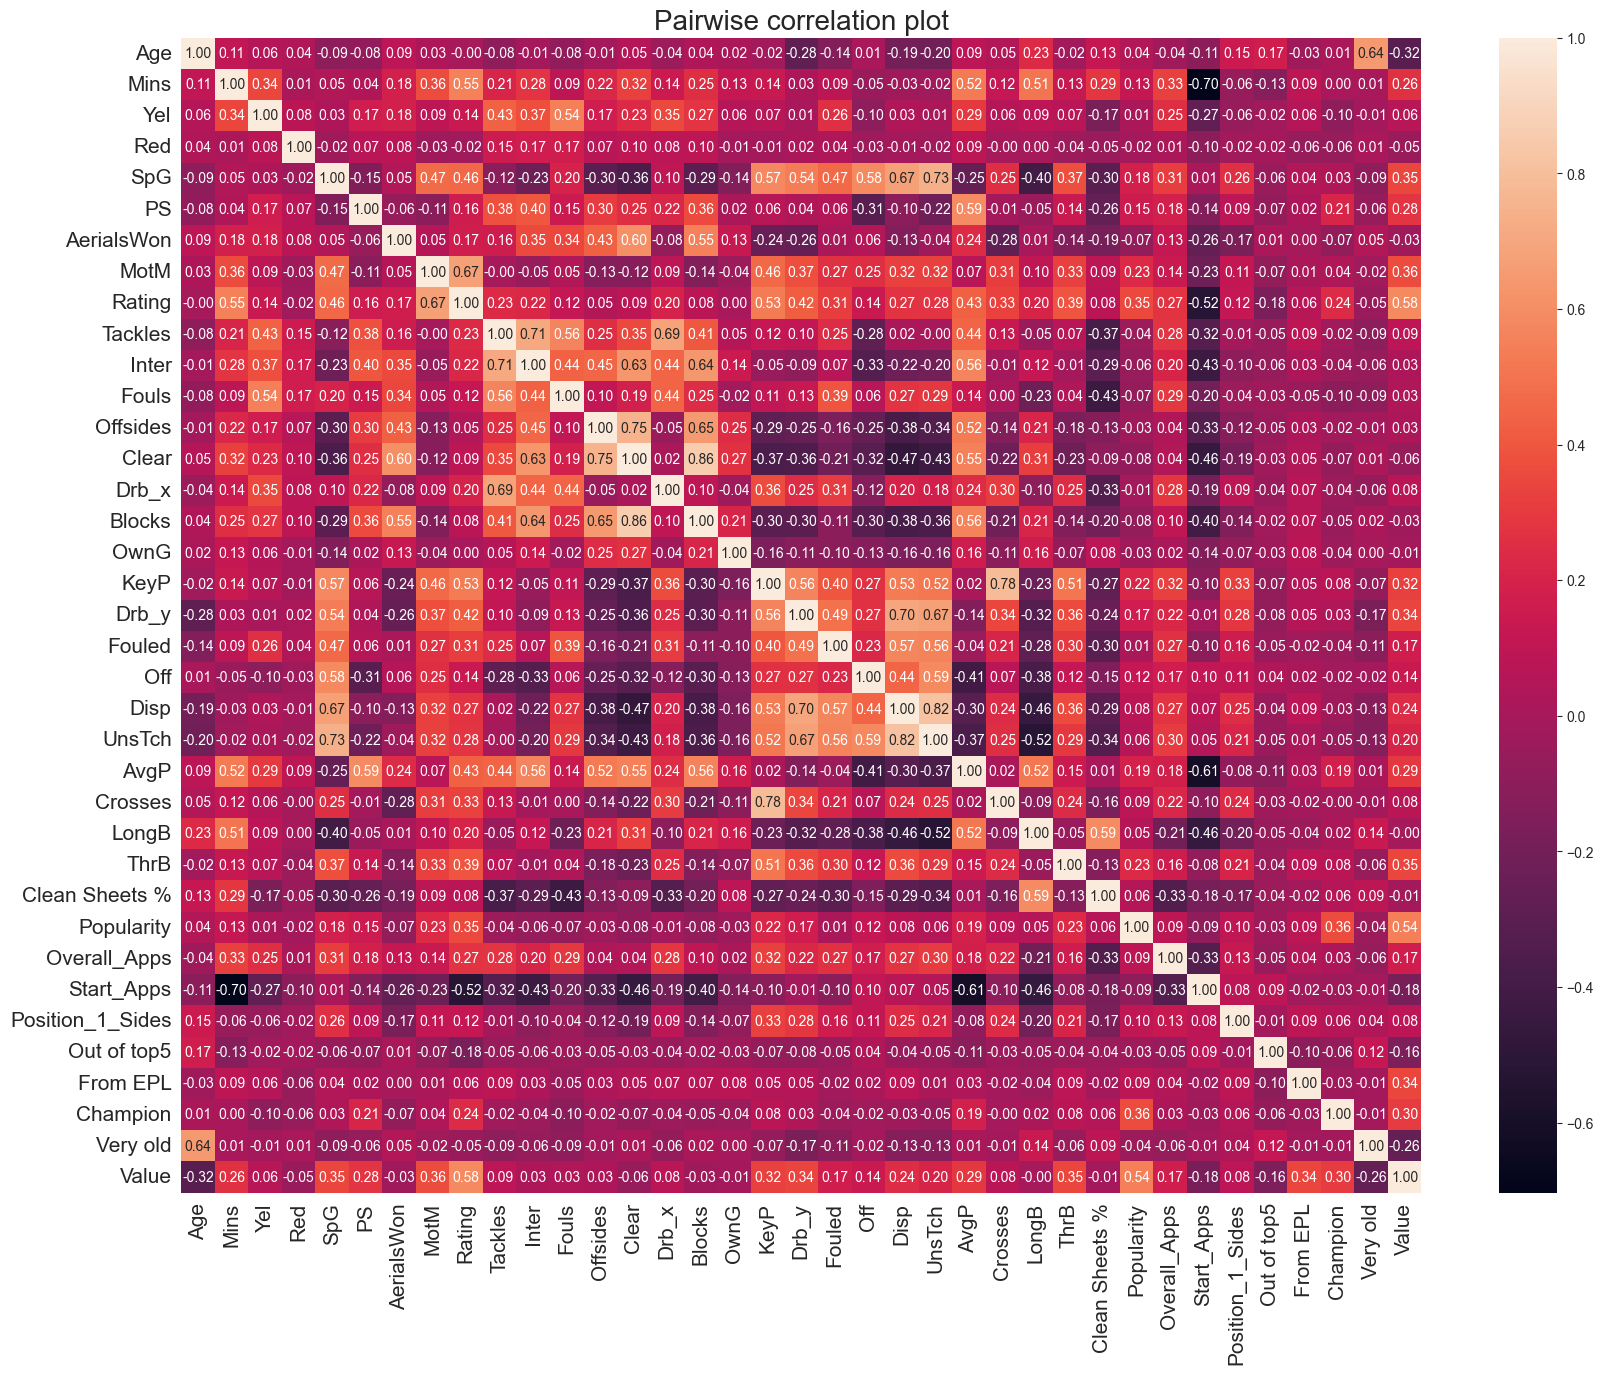

In [77]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Let`s check the variance of some variables and use filter methods of feature selection

In [44]:
low_variance_correlation = []

for item in all_data.columns:
    if (all_data[item].dtype == 'int64' or all_data[item].dtype == 'float') and not item.startswith('Minutes'):
        print(f'Variable: {item}')
        variance = all_data[item].values.var()
        correlation = np.corrcoef(all_data[item].values, all_data['Value'].values)[0][1]
        print(f'Its variance: {variance}')
        print(f'Its correlation with the target variable: {correlation}')
        print('=' * 25)
        
        if variance < 0.2 and correlation < 0.1:
            low_variance_correlation.append(item)

Variable: Age
Its variance: 16.22992888152291
Its correlation with the target variable: -0.32480813271727754
Variable: Mins
Its variance: 499480.52425897727
Its correlation with the target variable: 0.24684454725888857
Variable: Yel
Its variance: 7.229348766378711
Its correlation with the target variable: 0.09198648287442948
Variable: Red
Its variance: 0.17075891222418454
Its correlation with the target variable: -0.02522003841305955
Variable: SpG
Its variance: 0.427846627675709
Its correlation with the target variable: 0.351899663183083
Variable: PS
Its variance: 62.57501502218596
Its correlation with the target variable: 0.26199310700851086
Variable: AerialsWon
Its variance: 0.7295054551684621
Its correlation with the target variable: -0.02427373212302789
Variable: MotM
Its variance: 1.843871352032245
Its correlation with the target variable: 0.35050271825750795
Variable: Rating
Its variance: 0.06410839240639485
Its correlation with the target variable: 0.5768693761665808
Variable: T

In [79]:
#all_data.drop(low_variance_correlation, axis=1, inplace=True)

In [80]:
all_data.sample(5)

Age  Mins          Goals        Assists  Yel  Red  SpG    PS  \
1371   28  1669  (-0.028, 7.0]  (-0.014, 3.5]    6    0  1.3  68.8   
907    31  2702  (-0.028, 7.0]  (-0.014, 3.5]    1    0  0.0  59.3   
319    30  1631  (-0.028, 7.0]     (3.5, 7.0]    3    0  1.2  74.5   
427    28   928  (-0.028, 7.0]  (-0.014, 3.5]    2    0  0.7  69.5   
578    23  1554    (7.0, 14.0]    (7.0, 10.5]    2    0  3.5  73.0   

      AerialsWon  MotM  ...  Main side  Position_1_Sides  Team_rank  \
1371         0.5     0  ...          C                 3     C-tier   
907          0.4     4  ...          C                 1     B-tier   
319          1.0     2  ...          C                 3     C-tier   
427          1.1     1  ...          C                 1     B-tier   
578          1.2     3  ...          C                 1     B-tier   

      European tournament  Out of top5  From EPL  Champion    Position  \
1371                 None        False     False     False    Midfield   
907         Europa League        False      True     False  Goalkeeper   
319                  None        False     False     False    Midfield   
427                  None         True     False     False      Attack   
578         Europa League        False     False      True      Attack   

      Very old     Value  
1371     False   3500000  
907      False  10000000  
319      False   4000000  
427      False   3500000  
578      False  40000000  

[5 rows x 43 columns]

In [81]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1501 entries, 0 to 1545
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Age                  1501 non-null   int64   
 1   Mins                 1501 non-null   int64   
 2   Goals                1501 non-null   category
 3   Assists              1501 non-null   category
 4   Yel                  1501 non-null   int64   
 5   Red                  1501 non-null   int64   
 6   SpG                  1501 non-null   float64 
 7   PS                   1501 non-null   float64 
 8   AerialsWon           1501 non-null   float64 
 9   MotM                 1501 non-null   int64   
 10  Rating               1501 non-null   float64 
 11  Tackles              1501 non-null   float64 
 12  Inter                1501 non-null   float64 
 13  Fouls                1501 non-null   float64 
 14  Offsides             1501 non-null   float64 
 15  Clear                

In [82]:
all_data.columns

Index(['Age', 'Mins', 'Goals', 'Assists', 'Yel', 'Red', 'SpG', 'PS',
       'AerialsWon', 'MotM', 'Rating', 'Tackles', 'Inter', 'Fouls', 'Offsides',
       'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP', 'Drb_y', 'Fouled', 'Off',
       'Disp', 'UnsTch', 'AvgP', 'Crosses', 'LongB', 'ThrB', 'Clean Sheets %',
       'Popularity', 'Overall_Apps', 'Start_Apps', 'Main side',
       'Position_1_Sides', 'Team_rank', 'European tournament', 'Out of top5',
       'From EPL', 'Champion', 'Position', 'Very old', 'Value'],
      dtype='object')

In [83]:
all_data.sample(5)

Age  Mins          Goals        Assists  Yel  Red  SpG    PS  \
12     31  1354  (-0.028, 7.0]     (3.5, 7.0]    1    2  1.4  66.6   
784    36  2273  (-0.028, 7.0]  (-0.014, 3.5]    7    0  0.4  83.8   
260    31  2520  (-0.028, 7.0]  (-0.014, 3.5]    1    0  0.0  85.1   
32     20  1069  (-0.028, 7.0]  (-0.014, 3.5]    4    0  0.7  70.6   
1473   23  1073  (-0.028, 7.0]  (-0.014, 3.5]    3    0  0.8  71.2   

      AerialsWon  MotM  ...  Main side  Position_1_Sides  Team_rank  \
12           0.9     0  ...          C                 3     B-tier   
784          0.6     0  ...          C                 1     C-tier   
260          0.3     0  ...          C                 1     A-tier   
32           0.4     0  ...          C                 1     C-tier   
1473         0.2     0  ...          R                 1     B-tier   

      European tournament  Out of top5  From EPL  Champion    Position  \
12       Champions League        False     False     False    Midfield   
784                  None        False     False     False    Midfield   
260         Europa League        False      True     False  Goalkeeper   
32                   None        False     False     False     Defence   
1473     Champions League        False     False     False    Midfield   

      Very old     Value  
12       False   4000000  
784       True    500000  
260      False  28000000  
32       False   1500000  
1473     False  12000000  

[5 rows x 43 columns]

In [84]:
'''
exclude_feats = ['Age', 'Mins', 'Goals', 'Assists', 'From EPL', 'Champion', 'Value']

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
'''

'\nexclude_feats = [\'Age\', \'Mins\', \'Goals\', \'Assists\', \'From EPL\', \'Champion\', \'Value\']\n\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\nnumeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

In [85]:
'''
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.01
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
'''

'\nskewness = skewness[abs(skewness) > 0.75]\nprint("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))\n\nskewed_features = skewness.index\nlam = 0.01\nfor feat in skewed_features:\n    all_data[feat] = boxcox1p(all_data[feat], lam)\n'

In [86]:
'''
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
'''

'\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\nnumeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

**Feature transformation**

In [45]:
label_encoding = ['Mins', 'Goals', 'Assists', 'Main side', 'Team_rank', 'Position', 'European tournament']
one_hot_encoding = ['Main side', 'Position']

In [46]:
label_enc = LabelEncoder()

for label in label_encoding:
    all_data[label] = label_enc.fit_transform(all_data[label])

In [47]:
all_data = pd.get_dummies(all_data, columns=one_hot_encoding, drop_first=True)

In [48]:
df_train, df_test = divide_df(all_data)

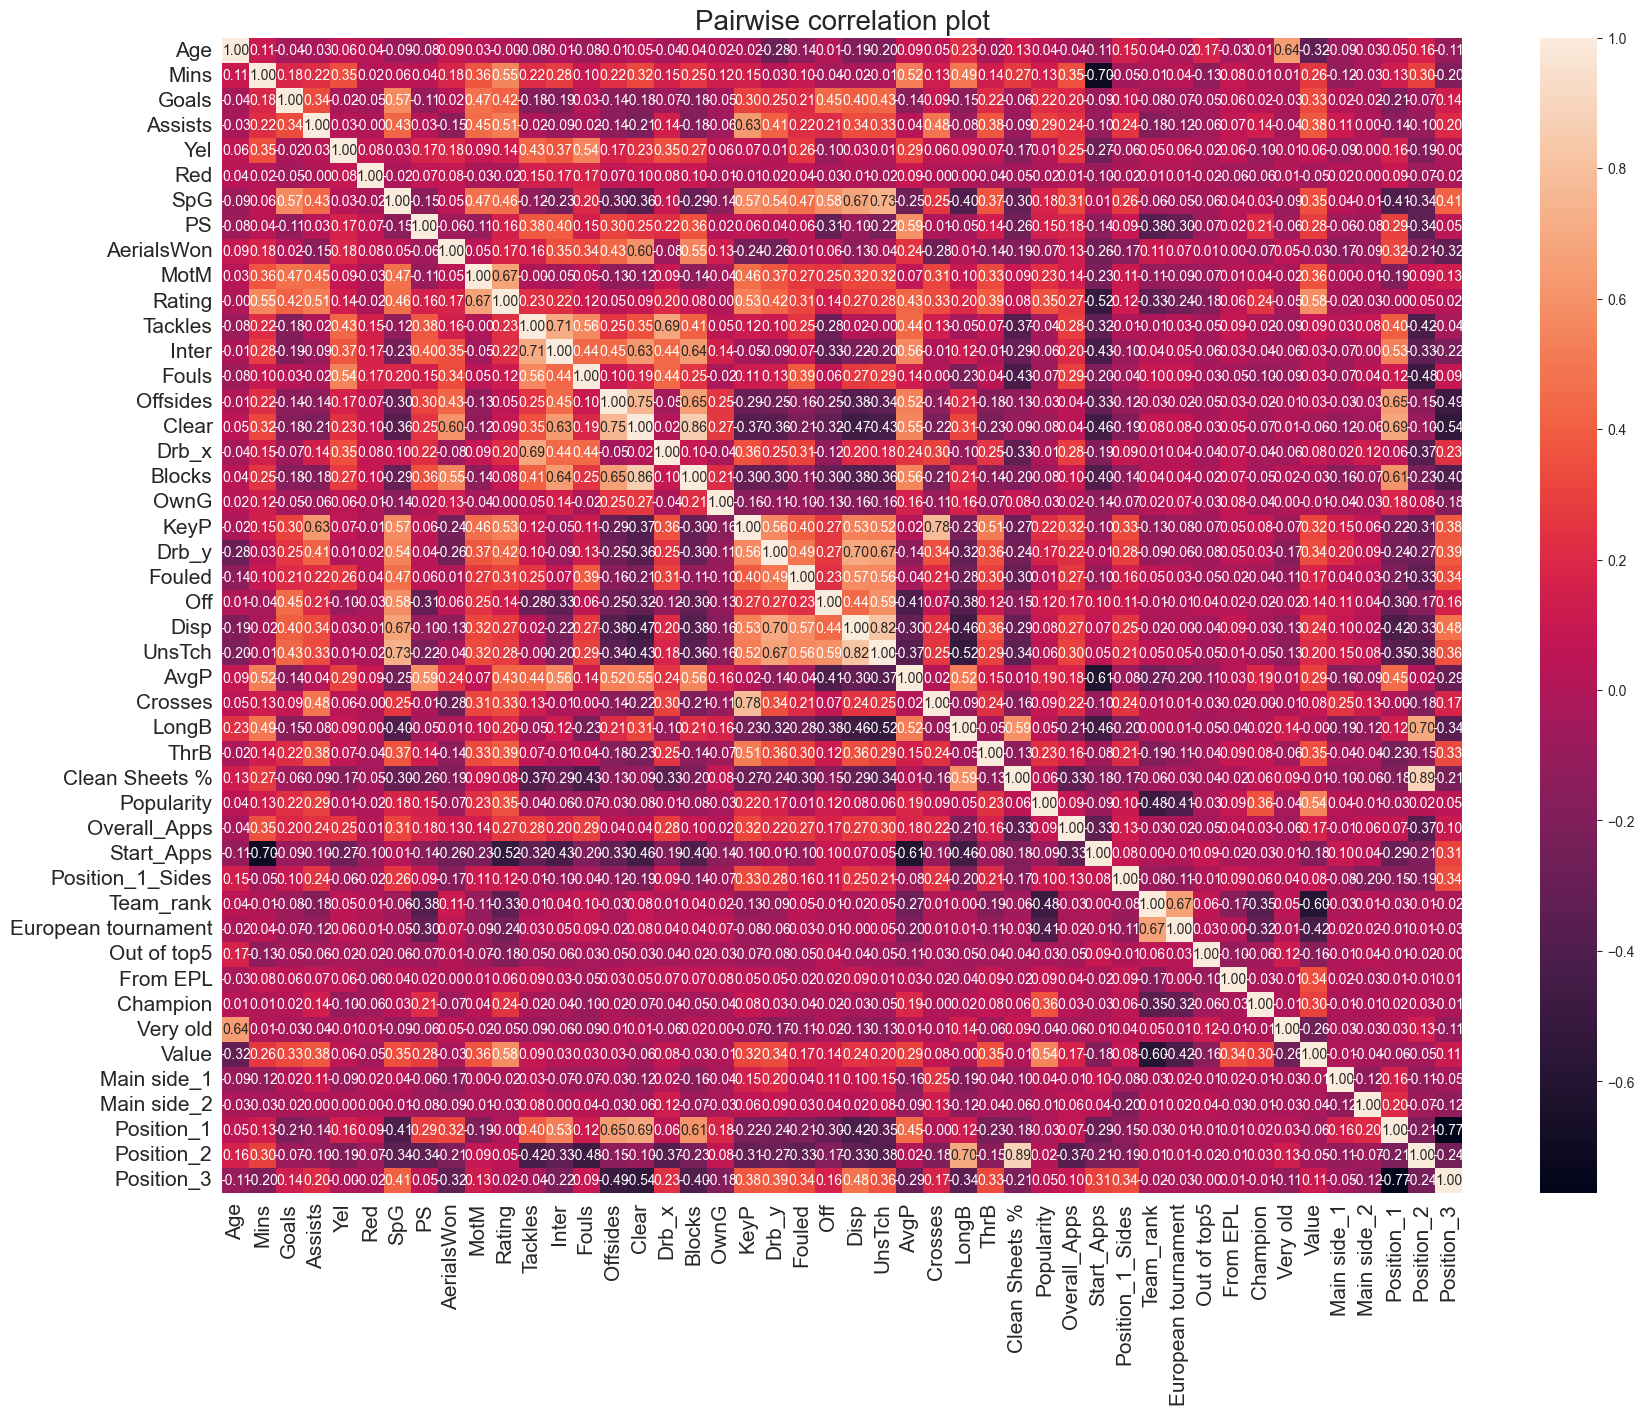

In [91]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

**3. LEARNING A MODEL**

This section will be divided into 3 parts. In the first part we will create the DecisionTree model to see how it makes decisions on the data and how well it performs. In the next part we will examine all the basic machine learning models in order to choose the best one. In the final part we will choose one of the algorithms and learn it via GridSearch with a larger hyperparameters grid 

In [92]:
# We use embedded method (ExtraTrees -> feature_importances_) and drop some other variables:
#all_data.drop(['Start_Apps', 'LongB', 'Yel', 'Drb_y', 'Tackles',
#               'Position_1_Sides', 'Clear', 'Assists', 'Position_3',
#               'Position_1', 'Main side_1', 'Position_2', 'Main side_2'], axis=1, inplace=True)

In [49]:
df_train, df_test = divide_df(all_data)

X_train, y_train = df_train.drop('Value', axis=1), df_train['Value']
X_test, y_test = df_test.drop('Value', axis=1), df_test['Value']

feature_names = X_train.columns

n_folds = 5

#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

*1. Decision Tree*

In this part we will create a basic decision tree and then visualize it. This model is good at representativeness and interpretability so we must know how to deal with it

In [50]:
# Train a basic model - without any hyperparameter fine-tuning
basic_decision_tree = DecisionTreeRegressor()

In [95]:
basic_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [96]:
def regression_metrics(prediction, reality):
    maximum = max(reality)
    minimum = min(reality)
    
    print(f'RMSE: {root_mean_squared_error(prediction, reality)}')
    print(f'Normalized RMSE: {root_mean_squared_error(prediction, reality)/(maximum-minimum)}')
    print(f'log RMSE: {root_mean_squared_log_error(np.abs(prediction), reality)}')
    print(f'MAPE: {mean_absolute_percentage_error(prediction, reality)}')
    print(f'R2 score: {r2_score(prediction, reality)}')
    
def show_predictions(model):
    answers = pd.DataFrame([test_names.values, y_test.values, pd.Series(model.predict(X_test))]).T
    answers.rename(columns={0: 'Name', 1: 'Test value', 2: 'Predicted value'}, inplace=True)
    
    return answers

def show_importances(features, model):
    feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['Importance'])
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    return feature_importances

def rmse_cv(model):
    kfolds = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, cv=kfolds, scoring='neg_mean_squared_error'))
    
    return rmse

In [97]:
regression_metrics(basic_decision_tree.predict(X_train), y_train)

RMSE: 0.0
Normalized RMSE: 0.0
log RMSE: 0.0
MAPE: 0.0
R2 score: 1.0


In [98]:
regression_metrics(basic_decision_tree.predict(X_test), y_test)

RMSE: 11664558.611856155
Normalized RMSE: 0.156047606847574
log RMSE: 0.7748132008031299
MAPE: 0.7336914762764332
R2 score: 0.5120098069821893


In [99]:
display(show_predictions(basic_decision_tree).sample(5))

Name Test value Predicted value
6          Kevin Strootman     800000        900000.0
245       Andoni Gorosabel    5000000       8000000.0
20           Djené Dakonam    2500000       1500000.0
161        Kacper Urbanski    7000000      15000000.0
68   Alexis Claude-Maurice    3500000       3000000.0

We see that this model expectedly overfits the data. Let`s somehow adjust our algorithm

In [100]:
vis_decision_tree = DecisionTreeRegressor(max_depth=3)

In [101]:
vis_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

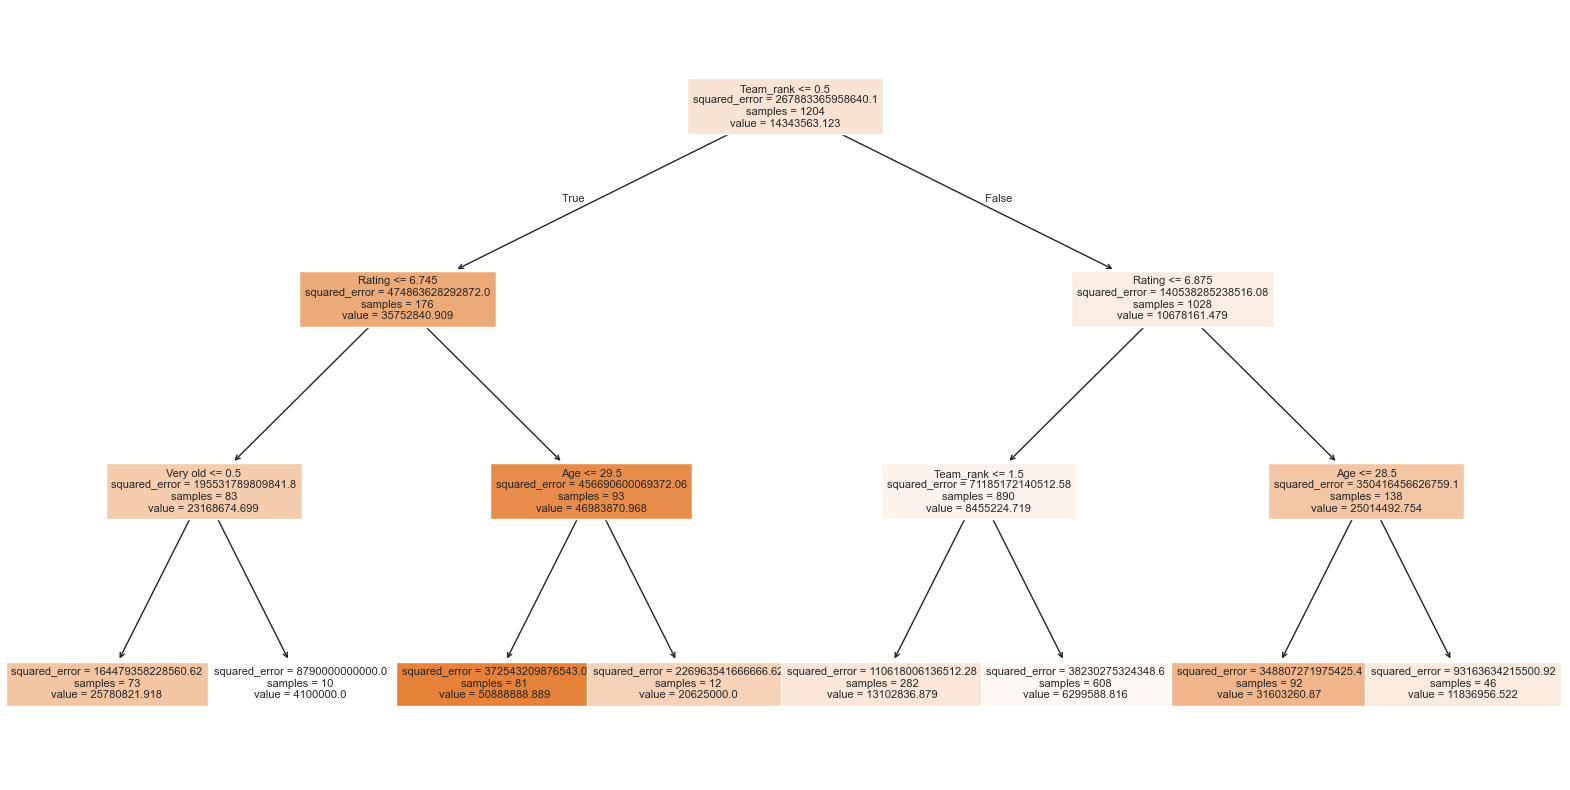

In [102]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(vis_decision_tree, feature_names=feature_names, filled=True, fontsize=8)

plt.show()

In [103]:
display(show_importances(feature_names, vis_decision_tree).head(8))

Importance
Team_rank           0.553755
Rating              0.308670
Age                 0.115435
Very old            0.022141
Position_1_Sides    0.000000
AvgP                0.000000
Crosses             0.000000
LongB               0.000000

The basic decision tree with max_depth = 3 makes its decisions based mainly on the rating, rank of the team in which a footballer plays and his age. So our new feature 'Team_rank' is very important for this ML algorithm. Let`s check the same thing for the first tree

In [104]:
display(show_importances(feature_names, basic_decision_tree))

Importance
Team_rank              0.327199
Rating                 0.206236
Age                    0.103831
Popularity             0.044189
European tournament    0.037789
Mins                   0.025272
From EPL               0.023975
Fouled                 0.019898
KeyP                   0.017083
SpG                    0.016953
Fouls                  0.016657
Very old               0.016647
PS                     0.016593
AerialsWon             0.014782
Yel                    0.012687
AvgP                   0.012059
Tackles                0.009337
UnsTch                 0.009164
LongB                  0.008942
Crosses                0.007014
Drb_y                  0.005948
Start_Apps             0.005778
Disp                   0.005412
Blocks                 0.003893
Overall_Apps           0.003474
Goals                  0.003313
ThrB                   0.003199
Drb_x                  0.002677
Position_1             0.002629
Clear                  0.002474
Off                    0.002389
Red                    0.002278
Position_1_Sides       0.001890
Inter                  0.001821
Main side_1            0.001803
Main side_2            0.001506
Clean Sheets %         0.000810
MotM                   0.000725
Offsides               0.000652
OwnG                   0.000498
Assists                0.000297
Position_3             0.000168
Champion               0.000053
Out of top5            0.000002
Position_2             0.000000

In [105]:
regression_metrics(vis_decision_tree.predict(X_train), y_train)

RMSE: 10620630.310128327
Normalized RMSE: 0.1180725993343894
log RMSE: 0.9386417896086304
MAPE: 0.6257528268054522
R2 score: 0.2726739017045824


In [106]:
regression_metrics(vis_decision_tree.predict(X_test), y_test)

RMSE: 9966380.91506271
Normalized RMSE: 0.13332951056940082
log RMSE: 0.9616402277702516
MAPE: 0.6036524768567091
R2 score: 0.36342559365592286


This model has problem with underfitting the data. So let`s use the RandomizedSearch algorithm in order to get the best possible tree. It will be faster than usual GridSearch and may give better performance.

In [107]:
decision_tree_param_grid = {
    'max_depth': [1, 3, 5, 7, 11, 13, 15],
    'min_samples_split': sp_randint(2, 16),
    'min_samples_leaf': sp_randint(2, 16)
}

In [108]:
tune_decision_tree = RandomizedSearchCV(DecisionTreeRegressor(), decision_tree_param_grid, n_iter=300, cv=5, random_state=42)
tune_decision_tree.fit(X_train, y_train)


KeyboardInterrupt



In [ ]:
best_decision_tree = tune_decision_tree.best_estimator_

In [ ]:
best_decision_tree.fit(X_train, y_train)

In [ ]:
show_importances(feature_names, best_decision_tree)

In [ ]:
regression_metrics(best_decision_tree.predict(X_train), y_train)

In [ ]:
regression_metrics(best_decision_tree.predict(X_test), y_test)

In [ ]:
display(show_predictions(best_decision_tree).sample(10))

This model performs better. But we see that it shows poor performance and doesn't use all the features we have. Let's check other ML algorithms and choose the best one

*2. Choosing a model*

In [ ]:
all_models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    BaggingRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    ExtraTreesRegressor(),
    
    SVR(),
    NuSVR(),
    
    LinearRegression(),
    SGDRegressor(),
    Ridge(), 
    Lasso(), 
    ElasticNet(), 
    BayesianRidge()
]

In [ ]:
cv_splits = KFold(n_splits=5, shuffle=True)

scores_table = pd.DataFrame(columns=['train RMSE', 'test RMSE', 'train RMSE 3std', 'test RMSE 3std'])
predictions_table = pd.DataFrame(y_train, index=y_train.index)

for alg in all_models:
    alg_name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, 
                                X_train, 
                                y_train,
                                cv=cv_splits,
                                scoring='neg_root_mean_squared_error',
                                return_train_score=True)
    
    scores_table.loc[alg_name, 'train RMSE'] = -cv_results['train_score'].mean()
    scores_table.loc[alg_name, 'test RMSE'] = -cv_results['test_score'].mean()
    #scores_table.loc[alg_name, 'train R2'] = cv_results['train_score'].mean()
    #scores_table.loc[alg_name, 'test R2'] = cv_results['test_score'].mean()
    
    scores_table.loc[alg_name, 'train RMSE 3std'] = cv_results['train_score'].std()*3
    scores_table.loc[alg_name, 'test RMSE 3std'] = cv_results['test_score'].std()*3
    #scores_table.loc[alg_name, 'train R2 3std'] = cv_results['train_score'].std()*3
    #scores_table.loc[alg_name, 'test R2 3std'] = cv_results['test_score'].std()*3
    
    alg.fit(X_train, y_train)
    
    predictions_table.loc[:, alg_name] = alg.predict(X_train)
    
scores_table.sort_values(by='test RMSE', ascending=True, inplace=True)

In [ ]:
display(scores_table)

We see that the best performance show ensemble and boosting methods like Gradient Boosting or Random Forest, but we also can notice that SVM algorithm obviously has an underfitting problem, so we can try to somehow fine-tune it (using kernels or adjusting the values of hyperparameters). But now we will try to use the RandomForestRegressor and find the best values of hyperparameters via GridSearchCV.

In [51]:
# GRID PARAMETERS

# 1. Lasso regression
lasso_grid_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175,
              200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1700, 2000, 2500, 3000,
              3500, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 14000, 16000, 18000, 20000,
              25000, 30000, 35000, 40000, 50000, 60000, 70000, 80000, 81500, 81510, 81520, 81530],
    'positive': [True, False]
}

# 2. Ridge regression
ridge_grid_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 17, 18, 18.2, 18.25, 18.26, 18.27, 18.28, 18.29, 18.3,
              18.31, 18.32, 18.33, 18.34, 18.35, 18.4, 18.5, 18.6, 19, 20, 22, 24, 25, 30, 40, 50, 60,
              70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200,
              1500, 1700, 2000, 2500, 3000, 3500, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    'positive': [True, False]
}

# 3. ElasticNet
elastic_grid_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10],
    'l1_ratio': np.arange(0.6, 0.9, 0.01)
}

# 4. KernelRidge regression
kernelridge_grid_params = {
    'kernel': ['linear', 'polynomial', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'coef0': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 7, 10]
}

# 5. GradientBoosting (n_iters = 3000)
gradient_grid_params = {
    'loss': ['squared_error', 'huber'],
    'n_estimators': [10, 30, 50, 70, 100, 300, 500, 1000],
    'learning_rate': np.arange(0, 1, 0.05),
    'max_depth': np.arange(1, 19, 2),
    'max_features': [None, 'sqrt'],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 19)
}

# 6. XGBoost
xgboost_grid_params = {
    'n_estimators': [10, 30, 50, 70, 100, 300, 500, 1000],
    'learning_rate': np.arange(0, 0.5, 0.025),
    'max_depth': np.arange(1, 19, 2),
    'gamma': [0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1, 3, 5, 7, 10],
    'min_child_weight': [0.5, 1, 1.05, 1.15, 1.35, 1.5, 1.7, 2, 2.5, 3, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500],
    'subsample': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.63, 0.66, 0.69, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'colsample_bytree':np.arange(0, 1, 0.05),
    'lambda': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'eval_metric': ['rmse']
}

# 7. LightGBM
lightgbm_grid_params = {
    'objective': ['regression', 'regression_l1', 'huber'],
    'n_estimators': [10, 30, 50, 70, 100, 300, 500, 1000],
    'learning_rate': np.arange(0, 0.5, 0.025),
    'max_depth': np.arange(1, 19, 2),
    'gamma': [0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1, 3, 5, 7, 10],
    'min_samples_leaf': np.arange(1, 19),
    'min_child_weight': [0.5, 1, 1.05, 1.15, 1.35, 1.5, 1.7, 2, 2.5, 3, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500],
    'subsample': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.63, 0.66, 0.69, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'subsample_freq': [0, 2, 3, 4, 5],
    'colsample_bytree':np.arange(0, 1, 0.05),
    'reg_lambda': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'reg_alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_bin': [0.5, 1, 1.05, 1.15, 1.35, 1.5, 1.7, 2, 2.5, 3, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500]
}

In [ ]:
random_forest_grid = {
    'max_depth': range(5, 14, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': np.arange(0.6, 1.1, 1),
    'n_estimators': [100]
}

In [ ]:
tune_random_forest = GridSearchCV(RandomForestRegressor(), random_forest_grid)
tune_random_forest.fit(X_train, y_train)

In [ ]:
best_random_forest = RandomForestRegressor(n_estimators=1000,
                                           max_depth=13,
                                           max_features=0.6,
                                           min_samples_leaf=1,
                                           min_samples_split=2)

In [ ]:
best_random_forest.fit(X_train, y_train)

In [ ]:
regression_metrics(best_random_forest.predict(X_train), y_train)

In [ ]:
regression_metrics(best_random_forest.predict(X_test), y_test)

In [ ]:
show_predictions(best_random_forest)

In [ ]:
basic_random_forest = RandomForestRegressor()
basic_random_forest.fit(X_train, y_train)

In [ ]:
extra_grid_params = {
    'max_depth': [5, 7, 9, 11, 13, 15, 17, 19, 21],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]
}

In [ ]:
tune_extra_trees = GridSearchCV(ExtraTreesRegressor(), extra_grid_params, scoring='r2', cv=5)
tune_extra_trees.fit(X_train, y_train)

In [ ]:
best_extra_trees = tune_extra_trees.best_estimator_
best_extra_trees.fit(X_train, y_train)

In [ ]:
best_extra_trees = ExtraTreesRegressor(max_depth=9, min_samples_leaf=3, n_estimators=1000)
best_extra_trees.fit(X_train, y_train)

In [ ]:
regression_metrics(best_extra_trees.predict(X_train), y_train)
print('=' * 25)
regression_metrics(best_extra_trees.predict(X_test), y_test)

In [ ]:
show_importances(feature_names, best_extra_trees)

In [ ]:
a = show_predictions(best_extra_trees)
display(a.sample(20))

In [ ]:
tune_xgboost_regressor = RandomizedSearchCV(XGBRegressor(), xgboost_grid_params, n_iter=30, scoring='neg_mean_squared_error', cv=5)
tune_xgboost_regressor.fit(X_train, y_train)

In [ ]:
best_xgboost_regressor = tune_xgboost_regressor.best_estimator_
best_xgboost_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_xgboost_regressor.predict(X_train), y_train)

In [ ]:
regression_metrics(best_xgboost_regressor.predict(X_test), y_test)

In [ ]:
pred = show_predictions(best_xgboost_regressor)

In [ ]:
pred[abs(pred['Test value'] - pred['Predicted value']) > 15000000]

In [ ]:
fine_ridge_regressor = GridSearchCV(Ridge(), ridge_grid_params, scoring='neg_mean_squared_error', cv=5)
fine_ridge_regressor.fit(X_train, y_train)

In [ ]:
best_ridge_regressor = fine_ridge_regressor.best_estimator_
best_ridge_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_ridge_regressor.predict(X_train), y_train)
print('=' * 25)
regression_metrics(best_ridge_regressor.predict(X_test), y_test)

In [ ]:
pred2 = show_predictions(best_ridge_regressor)

In [ ]:
pred2[abs(pred2['Test value'] - pred2['Predicted value']) > 15000000]

In [52]:
# Lasso. Best params: alpha=81500, positive=False
lasso = make_pipeline(RobustScaler(), Lasso(alpha=81500,
                                            positive=False))

# Ridge. Best params: alpha=18.3, positive=False
ridge = make_pipeline(RobustScaler(), Ridge(alpha=18.3,
                                            positive=False))

# ElasticNet. Best params: alpha=0.1, l1_ratio=0.8100000000000002
elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.1,
                                                   l1_ratio=0.8100000000000002,
                                                   positive=False))

# KernelRidge. Best params: kernel='polynomial', gamma=0.001, degree=3, coef0=31
kernelridge = KernelRidge(kernel='polynomial',
                          gamma=0.001,
                          degree=3,
                          coef0=31)

# GradientBoosting. Best params: loss='squared_error', n_estimators=600, learning_rate=0.05, min_samples_split=3, min_samples_leaf=3
gradient = GradientBoostingRegressor(loss='squared_error',
                                     n_estimators=600,
                                     learning_rate=0.05,
                                     min_samples_split=3,
                                     min_samples_leaf=3,
                                     max_depth=3,
                                     max_features=None)

# XGBoost. Best params: alpha=0, colsample_bytree=0.8, eval_metric='rmse', gamma=0.4, learning_rate=0.10000000000000002,
# max_depth=3,min_child_weight=2, n_estimators=250, subsample=0.9
xgboost = XGBRegressor(alpha=0,
                       colsample_bytree=0.8,
                       eval_metric='rmse',
                       gamma=0.4,
                       learning_rate=0.10000000000000002,
                       max_depth=3,
                       min_child_weight=2,
                       n_estimators=250,
                       subsample=0.9)

# LightGBM. Best params: colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_bin=1023, max_depth=9, min_child_weight=2,
# min_samples_leaf=3, n_estimators=500, objective='regression', reg_alpha=0.001, subsample=0.8, subsample_freq=2
lightgbm = LGBMRegressor(colsample_bytree=0.8,
                         gamma=0.4,
                         learning_rate=0.05,
                         max_bin=1023,
                         max_depth=9,
                         min_child_weight=2,
                         min_samples_leaf=3,
                         n_estimators=500,
                         objective='regression',
                         reg_alpha=0.001,
                         subsample=0.8,
                         subsample_freq=2)

# RandomForest
random_forest = RandomForestRegressor(n_estimators=1000,
                                      max_depth=13,
                                      max_features=0.6,
                                      min_samples_leaf=1,
                                      min_samples_split=2)

In [53]:
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elastic.fit(X_train, y_train)
kernelridge.fit(X_train, y_train)
gradient.fit(X_train, y_train)
xgboost.fit(X_train, y_train)
lightgbm.fit(X_train, y_train)
#random_forest.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 45
[LightGBM] [Info] Start training from score 14343563.122924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

RandomForestRegressor(max_depth=13, max_features=0.6, n_estimators=1000)

In [112]:
regression_metrics(lasso.predict(X_train), y_train)
print('=' * 25)
regression_metrics(lasso.predict(X_test), y_test)

RMSE: 8211615.669309589
Normalized RMSE: 0.09129089126525392
log RMSE: 0.8865125764565245
MAPE: 0.955368413583581
R2 score: 0.6489427586918067
RMSE: 7814666.459989679
Normalized RMSE: 0.10454403290956092
log RMSE: 0.9363069452791252
MAPE: 1.7012920861154663
R2 score: 0.6640098092883693


In [113]:
regression_metrics(ridge.predict(X_train), y_train)
print('=' * 25)
regression_metrics(ridge.predict(X_test), y_test)

RMSE: 8152192.75325342
Normalized RMSE: 0.09063026963038821
log RMSE: 0.8789099547857552
MAPE: 0.9662539235228591
R2 score: 0.6566413935928535
RMSE: 7784477.6395298885
Normalized RMSE: 0.10414016909070085
log RMSE: 0.9205924460037631
MAPE: 1.0901396268482064
R2 score: 0.6666185102941493


In [114]:
regression_metrics(elastic.predict(X_train), y_train)
print('=' * 25)
regression_metrics(elastic.predict(X_test), y_test)

RMSE: 8161687.789299071
Normalized RMSE: 0.09073582867480902
log RMSE: 0.8845208749962814
MAPE: 1.0331552662207824
R2 score: 0.6526504286119157
RMSE: 7789724.343179521
Normalized RMSE: 0.10421035910608055
log RMSE: 0.9523144984451241
MAPE: 2.4831559081987464
R2 score: 0.6628225724706447


In [115]:
regression_metrics(kernelridge.predict(X_train), y_train)
print('=' * 25)
regression_metrics(kernelridge.predict(X_test), y_test)

RMSE: 4989042.798043679
Normalized RMSE: 0.055464622546344405
log RMSE: 0.6865912466296713
MAPE: 0.7813719860148863
R2 score: 0.8938110505468262
RMSE: 7256196.3510032045
Normalized RMSE: 0.09707286088298601
log RMSE: 0.8333671046583859
MAPE: 1.1016228429523705
R2 score: 0.7466681809949982


In [116]:
regression_metrics(gradient.predict(X_train), y_train)
print('=' * 25)
regression_metrics(gradient.predict(X_test), y_test)

RMSE: 3035149.3223732016
Normalized RMSE: 0.03374262726373765
log RMSE: 0.5112761718885016
MAPE: 0.45805229450685864
R2 score: 0.9616581548889271
RMSE: 6728173.522802455
Normalized RMSE: 0.09000901033849439
log RMSE: 0.8807537736161397
MAPE: 6.238451827769261
R2 score: 0.77887827695061


In [117]:
regression_metrics(xgboost.predict(X_train), y_train)
print('=' * 25)
regression_metrics(xgboost.predict(X_test), y_test)

RMSE: 3327856.8911169497
Normalized RMSE: 0.036996741424312946
log RMSE: 0.5723846023895046
MAPE: 0.6403622540238214
R2 score: 0.9536532163619995
RMSE: 6805005.995266721
Normalized RMSE: 0.09103686950189593
log RMSE: 0.6292657061451588
MAPE: 0.5908576736047846
R2 score: 0.7718998193740845


In [118]:
regression_metrics(lightgbm.predict(X_train), y_train)
print('=' * 25)
regression_metrics(lightgbm.predict(X_test), y_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 252801.1854958931
Normalized RMSE: 0.0028104634296374996
log RMSE: 0.11254333469270168
MAPE: 0.04082488880874592
R2 score: 0.9997597856619856
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 6627072.985890874
Normalized RMSE: 0.08865649479452674
log RMSE: 0.6078019800629454
MAPE: 0.736424617582444
R2 score: 0.7865464726658473


In [119]:
regression_metrics(random_forest.predict(X_train), y_train)
print('=' * 25)
regression_metrics(random_forest.predict(X_test), y_test)

RMSE: 3009900.482894546
Normalized RMSE: 0.033461928659194506
log RMSE: 0.35511871727861954
MAPE: 0.20055905000859883
R2 score: 0.9582669232985389
RMSE: 7110808.193107791
Normalized RMSE: 0.09512786880411761
log RMSE: 0.5719115110550841
MAPE: 0.37790991759768106
R2 score: 0.7083952804007829


In [54]:
class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]
        
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [55]:
av_model = AveragingModel([kernelridge, gradient, xgboost, lightgbm])
av_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 45
[LightGBM] [Info] Start training from score 14343563.122924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

AveragingModel(models=[KernelRidge(coef0=31, gamma=0.001, kernel='polynomial'),
                       GradientBoostingRegressor(learning_rate=0.05,
                                                 min_samples_leaf=3,
                                                 min_samples_split=3,
                                                 n_estimators=600),
                       XGBRegressor(alpha=0, base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    e...
                                    min_child_weight=2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=250,
                                    n_jobs=None, num_parallel_tree=None, ...),
                       LGBMRegressor(colsample_bytree=0.8, gamma=0.4,
                                     learning_rate=0.05, max_bin=1023,
                                     max_depth=9, min_child_weight=2,
                                     min_samples_leaf=3, n_estimators=500,
                                     objective='regression', reg_alpha=0.001,
                                     subsample=0.8, subsample_freq=2)])

In [122]:
regression_metrics(av_model.predict(X_train), y_train)
print('=' * 25)
regression_metrics(av_model.predict(X_test), y_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 2679665.4102855916
Normalized RMSE: 0.029790610453425143
log RMSE: 0.4615560930426775
MAPE: 0.44442681021950203
R2 score: 0.9701784115498724
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 6282542.089994096
Normalized RMSE: 0.08404738581931902
log RMSE: 0.5997632258436378
MAPE: 0.6053912040350383
R2 score: 0.8004186840542649


In [131]:
pred = show_predictions(av_model)
pred[abs(pred['Test value'] - pred['Predicted value']) > 5000000]

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3


Name Test value  Predicted value
0            Paulo Dybala   20000000  32527926.230436
1        Pervis Estupiñán   30000000  23665250.252106
2              Aimar Oroz   15000000   9278169.596091
8              João Félix   30000000  53241533.960154
9           Igor Zubeldia   22000000  15732509.289156
..                    ...        ...              ...
280         Karim Adeyemi   28000000  16224745.797773
281         Harry Maguire   18000000  30517921.758165
285            Robin Hack    8000000   18496184.02855
288          Nathan Tella   23000000  15680360.312864
294  Giorgi Mamardashvili   35000000  21590202.387186

[82 rows x 3 columns]

In [125]:
class StackingAverageModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for model in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models_)))
        
        for index, model in enumerate(self.base_models):
            for train_indices, holdout_indices in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[index].append(instance)
                instance.fit(X.iloc[train_indices, :], y[train_indices])
                predictions = instance.predict(X.iloc[holdout_indices, :])
                out_of_fold_predictions[holdout_indices, index] = predictions
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        
        print(out_of_fold_predictions)
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack(
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) for base_models in self.base_models_
        )
        
        return self.meta_model_.predict(meta_features)

In [126]:
stacking_model = StackingAverageModels([lasso, lightgbm, kernelridge, gradient, xgboost], lightgbm)
stacking_model.fit(X_train, y_train)

IndexingError: Too many indexers

In [ ]:
regression_metrics(stacking_model.predict(X_train), y_train)
print('=' * 25)
regression_metrics(stacking_model.predict(X_test), y_test)

In [56]:
with open('final_model.pkl', 'wb') as file:
    dill.dump(av_model, file)